# Importing packages

In [59]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [60]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [61]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [62]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "SVM_linear_" #what data did you put in
fileName_common = "EchoAdj_clinSplit_second_red025_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250523_v1" #date and versioning

saving_dirrectory = os.path.join("012 Processed Data","019_clinicalSplit", "SecondFeatRed")
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "SVM_linear_EchoAdj_clinSplit_second_red025_", 
                                     folderName_common= "250523_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = os.path.join("012 Processed Data","019_clinicalSplit")
figFolder = makingFolder 


In [63]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [64]:
#parameters of SVM 
red_factor = 0

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]
# rank_weights = [0, 0.2, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]

In [65]:
# test set patients selected 1/5 from the sorted mean KPS scores for the CA+ and CA- subgroups of all patients
testSetPatients = ['T-01', 'B-02', 'I-01', 'Y-02', 'F-03', 'B-03', 'F-01', 'G-03', 'Q-01', 'C-01']
trainSetPatients = ['C-03', 'E-01', 'E-02', 'G-02', 'I-03', 'J-02', 'K-02', 'M-02', 'N-03', 'O-03', 'Q-02', 'Q-03', 'V-02', 'W-01', 'X-01', 'X-02',
                    'A-02', 'C-02', 'E-03', 'H-01', 'H-02', 'M-01', 'N-01', 'N-02', 'P-01', 'P-02', 'R-01', 'R-03', 'S-02', 'T-02', 'V-01', 'W-02', 'Y-01', 'Z-01']

# importing our data

In [66]:
dataFileName = "DF_SVM_noNotes_EchoAdj__20250502_v1.xlsx"

In [67]:
# "C:\Users\maega\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\015_Mistic2025\DFsForSVM_noNotes__20250502_v1\DF_SVM_noNotes_EchoAdj__20250502_v1.xlsx"

In [68]:
#file for the feature list
priorFeaturesName = 'SVM_model_comparison_ClinicalSplit.xlsx'
#sheets with prior selected features for this same starting feature list "feature selection"
#header rows 2, 'model' , 'feature reduction', in column 0
priorFeatures_df = pd.read_excel(priorFeaturesName, sheet_name='best feats', header = [0,1]) #data set we are using
priorModel = 'EchoAdj' #original data conditions
priorFeatureRed = 0.25 #feature reduction rate

priorFeaturesList = list(priorFeatures_df[priorModel, priorFeatureRed].dropna())

x_columns_toKeep = priorFeaturesList #features to use in the initial feature list

In [69]:
# Import dataset
dataTable = pd.read_excel(dataFileName, sheet_name = "knownPts", header = 0) #the dataset we are using

dataTable.index = dataTable['DeID']

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'CA_status_yes']

#columns to use for the y data 
y_column_Classification = 'CA_status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)
x_columns_Compare = [feature for feature in x_columns_toKeep if feature in X.columns]
X = X[x_columns_Compare]

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

HematologicTx  HematologicTx_True
DeID                                   
B-02              0                   0
C-03              0                   0
E-01              0                   0
E-02              0                   0
F-03              1                   1
G-02              0                   0
I-01              0                   0
I-03              0                   0
J-02              0                   0
K-02              0                   0
M-02              0                   0
N-03              0                   0
O-03              0                   0
Q-02              0                   0
Q-03              0                   0
T-01              0                   0
V-02              0                   0
W-01              0                   0
X-01              0                   0
X-02              0                   0
Y-02              0                   0
A-02              0                   0
B-03              0                   0
C-01              0                   0
C-02              1                   1
E-03              0                   0
F-01              1                   1
G-03              0                   0
H-01              0                   0
H-02              1                   1
M-01              0                   0
N-01              0                   0
N-02              0                   0
P-01              0                   0
P-02              1                   1
Q-01              0                   0
R-01              1                   1
R-03              0                   0
S-02              0                   0
T-02              1                   1
V-01              1                   1
W-02              0                   0
Y-01              0                   0
Z-01              0                   0

# Setting up classifier

## Scaling data and defining test set

In [70]:
scaler = StandardScaler().set_output(transform = 'pandas')
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
#                                                     stratify = y_all, 
#                                                     random_state= randomSeed, 
#                                                     test_size= test_size_numb)

X_train = X_all.loc[trainSetPatients]
y_train = y_all.loc[trainSetPatients]
X_test = X_all.loc[testSetPatients]
y_test = y_all.loc[testSetPatients]

# max(X_all[:,0])
X_all.max().max()

6.417045433898106

In [71]:
outputToExcel(df_data=dataTable.loc[trainSetPatients], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "train_data")
outputToExcel(df_data=dataTable.loc[testSetPatients], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "test_data")

## define cross validation

In [72]:
#convert everything to numpy arrays to get the rest to run 
X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()
X_all = X_all.to_numpy()

In [73]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [74]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.8642857142857142,
 'auc': 0.888888888888889,
 'score': 0.8765873015873016,
 'C': 1}

In [75]:
test_y_predict = test.predict(X_test)
decision_values = test.decision_function(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_y_predict).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 
                       'false neg': fn, 'true pos': tp,
                       'precision or PPV': precision, 
                       'recall or TPR': recall, 'specificity or TNR': specificity}
dict_temp_blindpred


{'f1': 0.25,
 'auc': 0.44,
 'true neg': 3,
 'false pos': 2,
 'false neg': 4,
 'true pos': 1,
 'precision or PPV': 0.3333333333333333,
 'recall or TPR': 0.2,
 'specificity or TNR': 0.6}

## testing other models

In [76]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [77]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print( "ROC: ", roc_auc_score(y_test, y_pred))

importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(ax=ax)
# fig.tight_layout()

F1:  0.5
ROC:  0.6


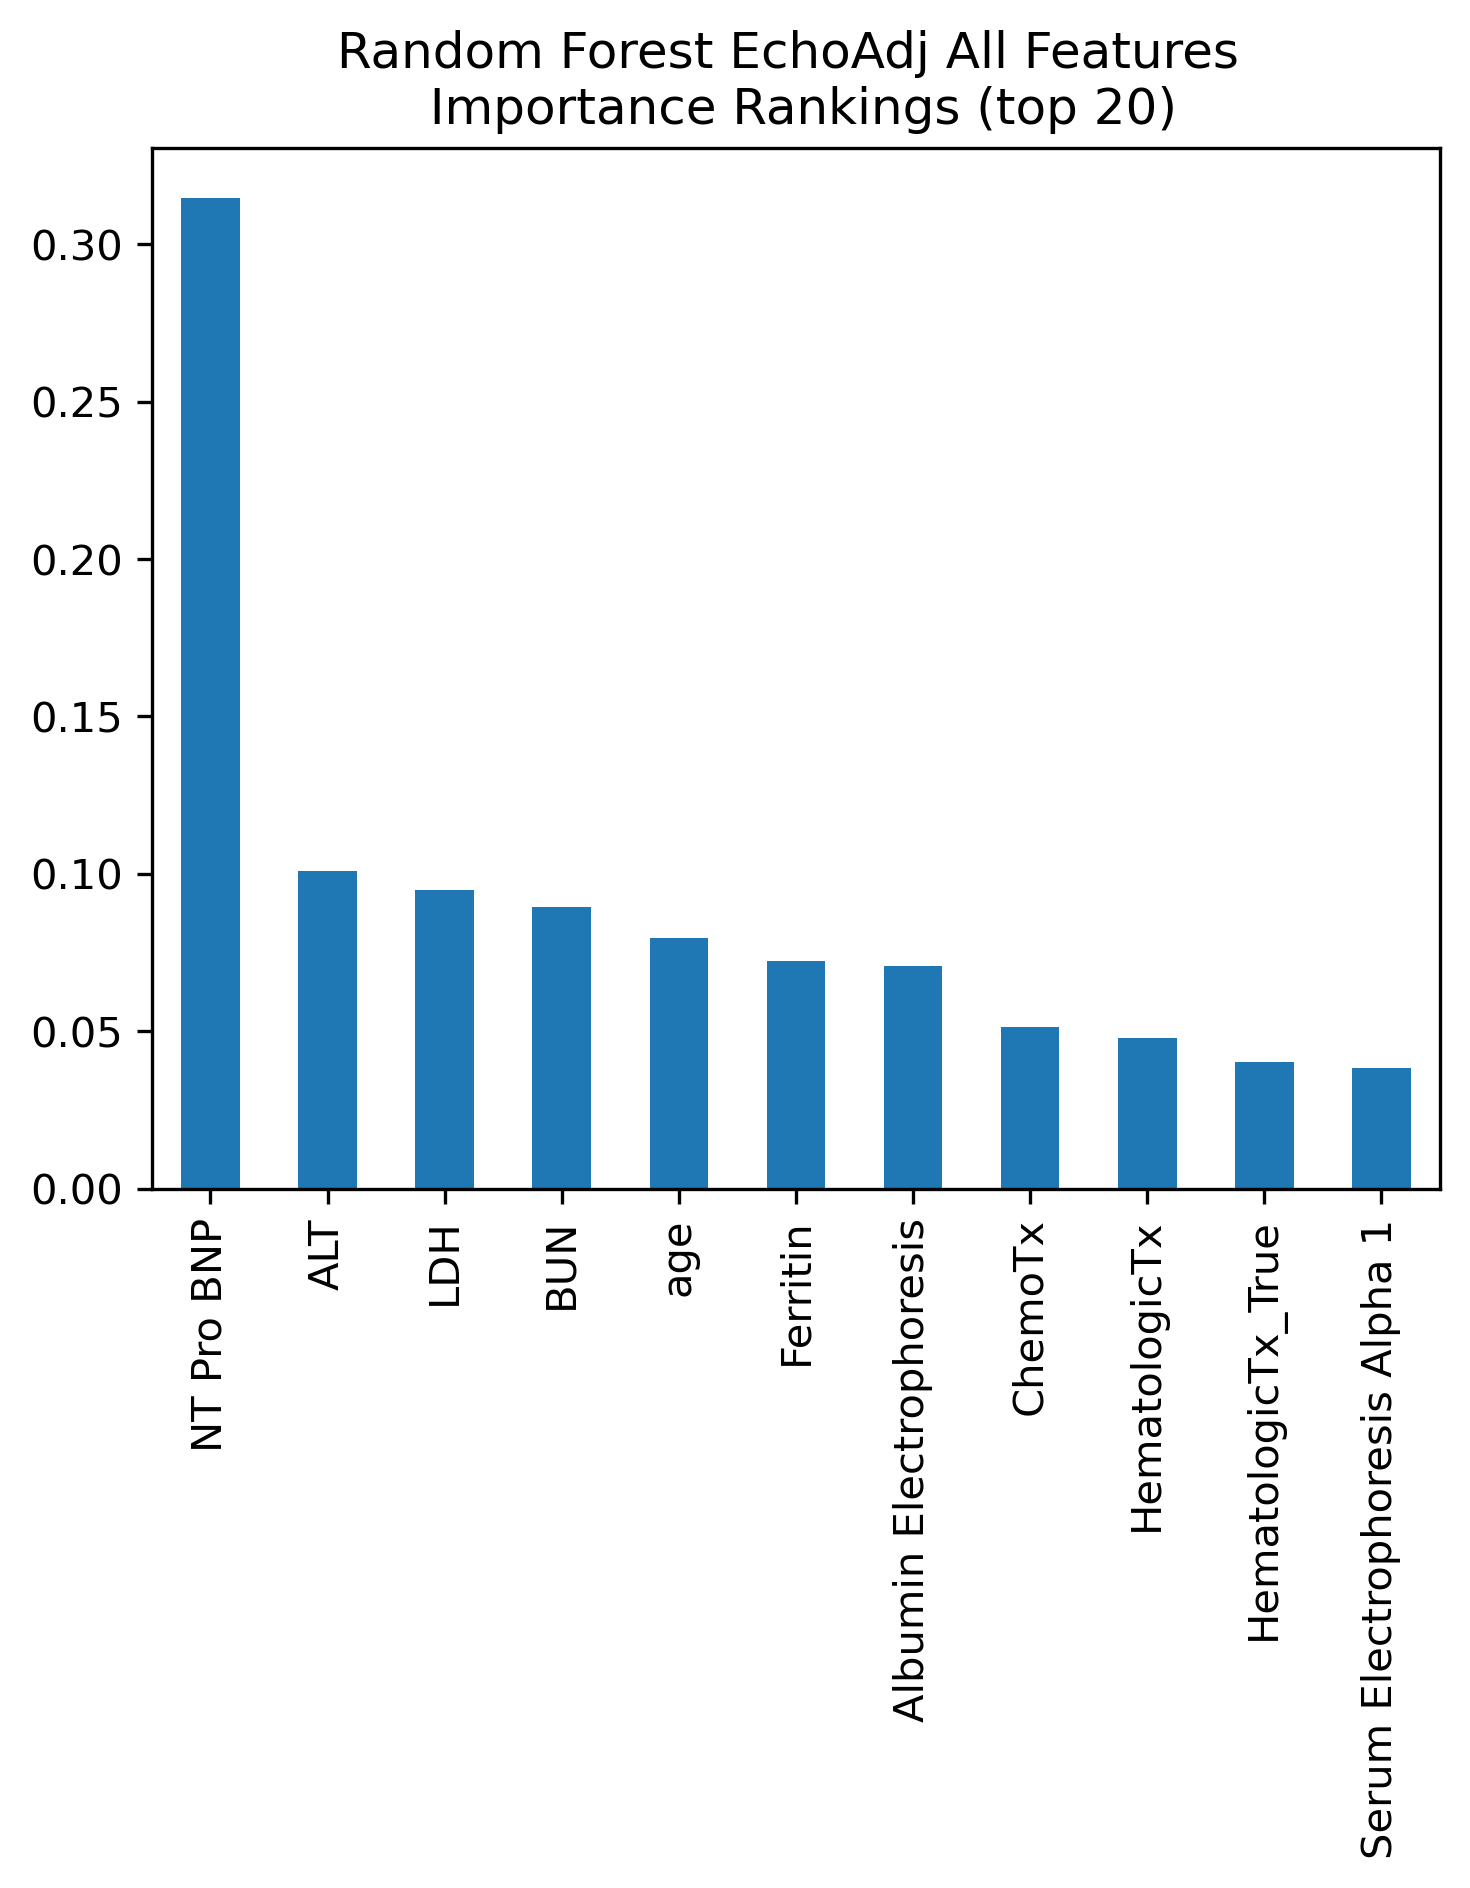

In [78]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = forest_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest EchoAdj All Features \n Importance Rankings (top 20)")

# Show the plot
plt.show()

In [79]:
what_train = pd.DataFrame(X_train, columns = X.columns) 
what_test = pd.DataFrame(X_test, columns = X.columns) 

In [80]:
what_train

age   ChemoTx  HematologicTx  HematologicTx_True       ALT  \
0  -0.389485  0.563970      -0.471405           -0.471405  1.794743   
1  -1.275899 -0.742065      -0.471405           -0.471405 -0.974700   
2   0.102967 -0.742065      -0.471405           -0.471405  0.172641   
3  -2.654766 -0.742065      -0.471405           -0.471405 -0.420812   
4   0.398439 -0.742065      -0.471405           -0.471405  0.014387   
5   0.496929 -0.089048      -0.471405           -0.471405  1.438672   
6   0.496929 -0.089048      -0.471405           -0.471405 -0.539502   
7   0.693910 -0.742065      -0.471405           -0.471405  2.625577   
8   0.595420 -0.742065      -0.471405           -0.471405 -0.974700   
9   0.792401 -0.742065      -0.471405           -0.471405  0.251768   
10  0.595420 -0.742065      -0.471405           -0.471405 -0.064740   
11 -2.162313 -0.742065      -0.471405           -0.471405 -0.974700   
12  1.580324 -0.089048      -0.471405           -0.471405 -0.302121   
13 -0.586466  1.216987      -0.471405           -0.471405 -0.618629   
14  1.678815 -0.742065      -0.471405           -0.471405 -0.420812   
15  0.004477 -0.742065      -0.471405           -0.471405  0.212204   
16  1.087872 -0.742065      -0.471405           -0.471405 -0.658192   
17 -0.389485  0.563970       2.121320            2.121320 -0.104304   
18 -0.094014 -0.742065      -0.471405           -0.471405  0.093514   
19 -0.684956 -0.742065      -0.471405           -0.471405  0.093514   
20  0.201458  0.563970       2.121320            2.121320 -0.974700   
21 -1.571371 -0.089048      -0.471405           -0.471405  0.172641   
22  1.580324 -0.742065      -0.471405           -0.471405 -0.302121   
23  1.284853 -0.089048      -0.471405           -0.471405 -0.064740   
24  1.383343 -0.089048      -0.471405           -0.471405  2.427759   
25  0.102967  1.870004       2.121320            2.121320 -0.143867   
26  0.496929  1.216987       2.121320            2.121320 -0.302121   
27 -0.094014 -0.742065      -0.471405           -0.471405  0.291331   
28  0.595420  0.563970      -0.471405           -0.471405  0.093514   
29 -0.290995  1.216987       2.121320            2.121320 -0.974700   
30  0.299948  0.563970       2.121320            2.121320 -0.222994   
31  0.890891 -0.742065      -0.471405           -0.471405  4.049862   
32 -0.389485  2.523022      -0.471405           -0.471405 -0.381248   
33  0.890891 -0.742065      -0.471405           -0.471405 -0.025177   

    Albumin Electrophoresis       BUN  Ferritin       LDH  \
0                 -0.159029  1.067717 -0.509115  0.620072   
1                 -0.702506 -1.642642 -0.845955 -1.681579   
2                 -0.172616  0.992429  4.027776  0.152871   
3                 -0.199790 -0.739189 -0.550929 -0.053247   
4                  6.417045 -0.362750 -0.771618 -0.128824   
5                 -0.023160 -0.889764  0.001953  1.066660   
6                 -0.172616  1.971170 -0.574160  0.139130   
7                  0.058362  2.121745 -0.518407  0.592589   
8                 -0.104681 -1.642642 -0.845955 -1.681579   
9                 -0.063920 -0.287462 -0.348825  0.468918   
10                -0.050333  0.691278 -0.130460 -0.328071   
11                -0.118268  0.164264 -0.694958 -0.465483   
12                -0.254137 -0.061599  1.460821  0.077294   
13                -0.172616 -0.739189  0.640789 -0.754048   
14                -0.159029  0.314840  0.529283 -0.451742   
15                -0.023160  2.422896 -0.374379 -0.218141   
16                -0.036746  0.465415 -0.562545  0.372730   
17                 0.071949 -0.061599 -0.362763 -0.740307   
18                -0.430767 -0.588613  1.149534  0.358989   
19                -0.702506 -0.588613 -0.372055 -0.602895   
20                -0.702506 -1.642642 -0.845955 -1.681579   
21                 0.058362 -0.287462  1.182056  1.808685   
22                -0.063920 -0.588613 -0.416193 -0.513577   
23                -0.050333  0.164264  0.127397  0.826189  

In [81]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(what_train[list(top_20_importances.index[:8])], y_train)
y_pred = rnd_clf.predict(what_test[list(top_20_importances.index[:8])])
# print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print( "ROC: ", roc_auc_score(y_test, y_pred))

importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= what_train[list(top_20_importances.index[:8])].columns)

F1:  0.0
ROC:  0.4


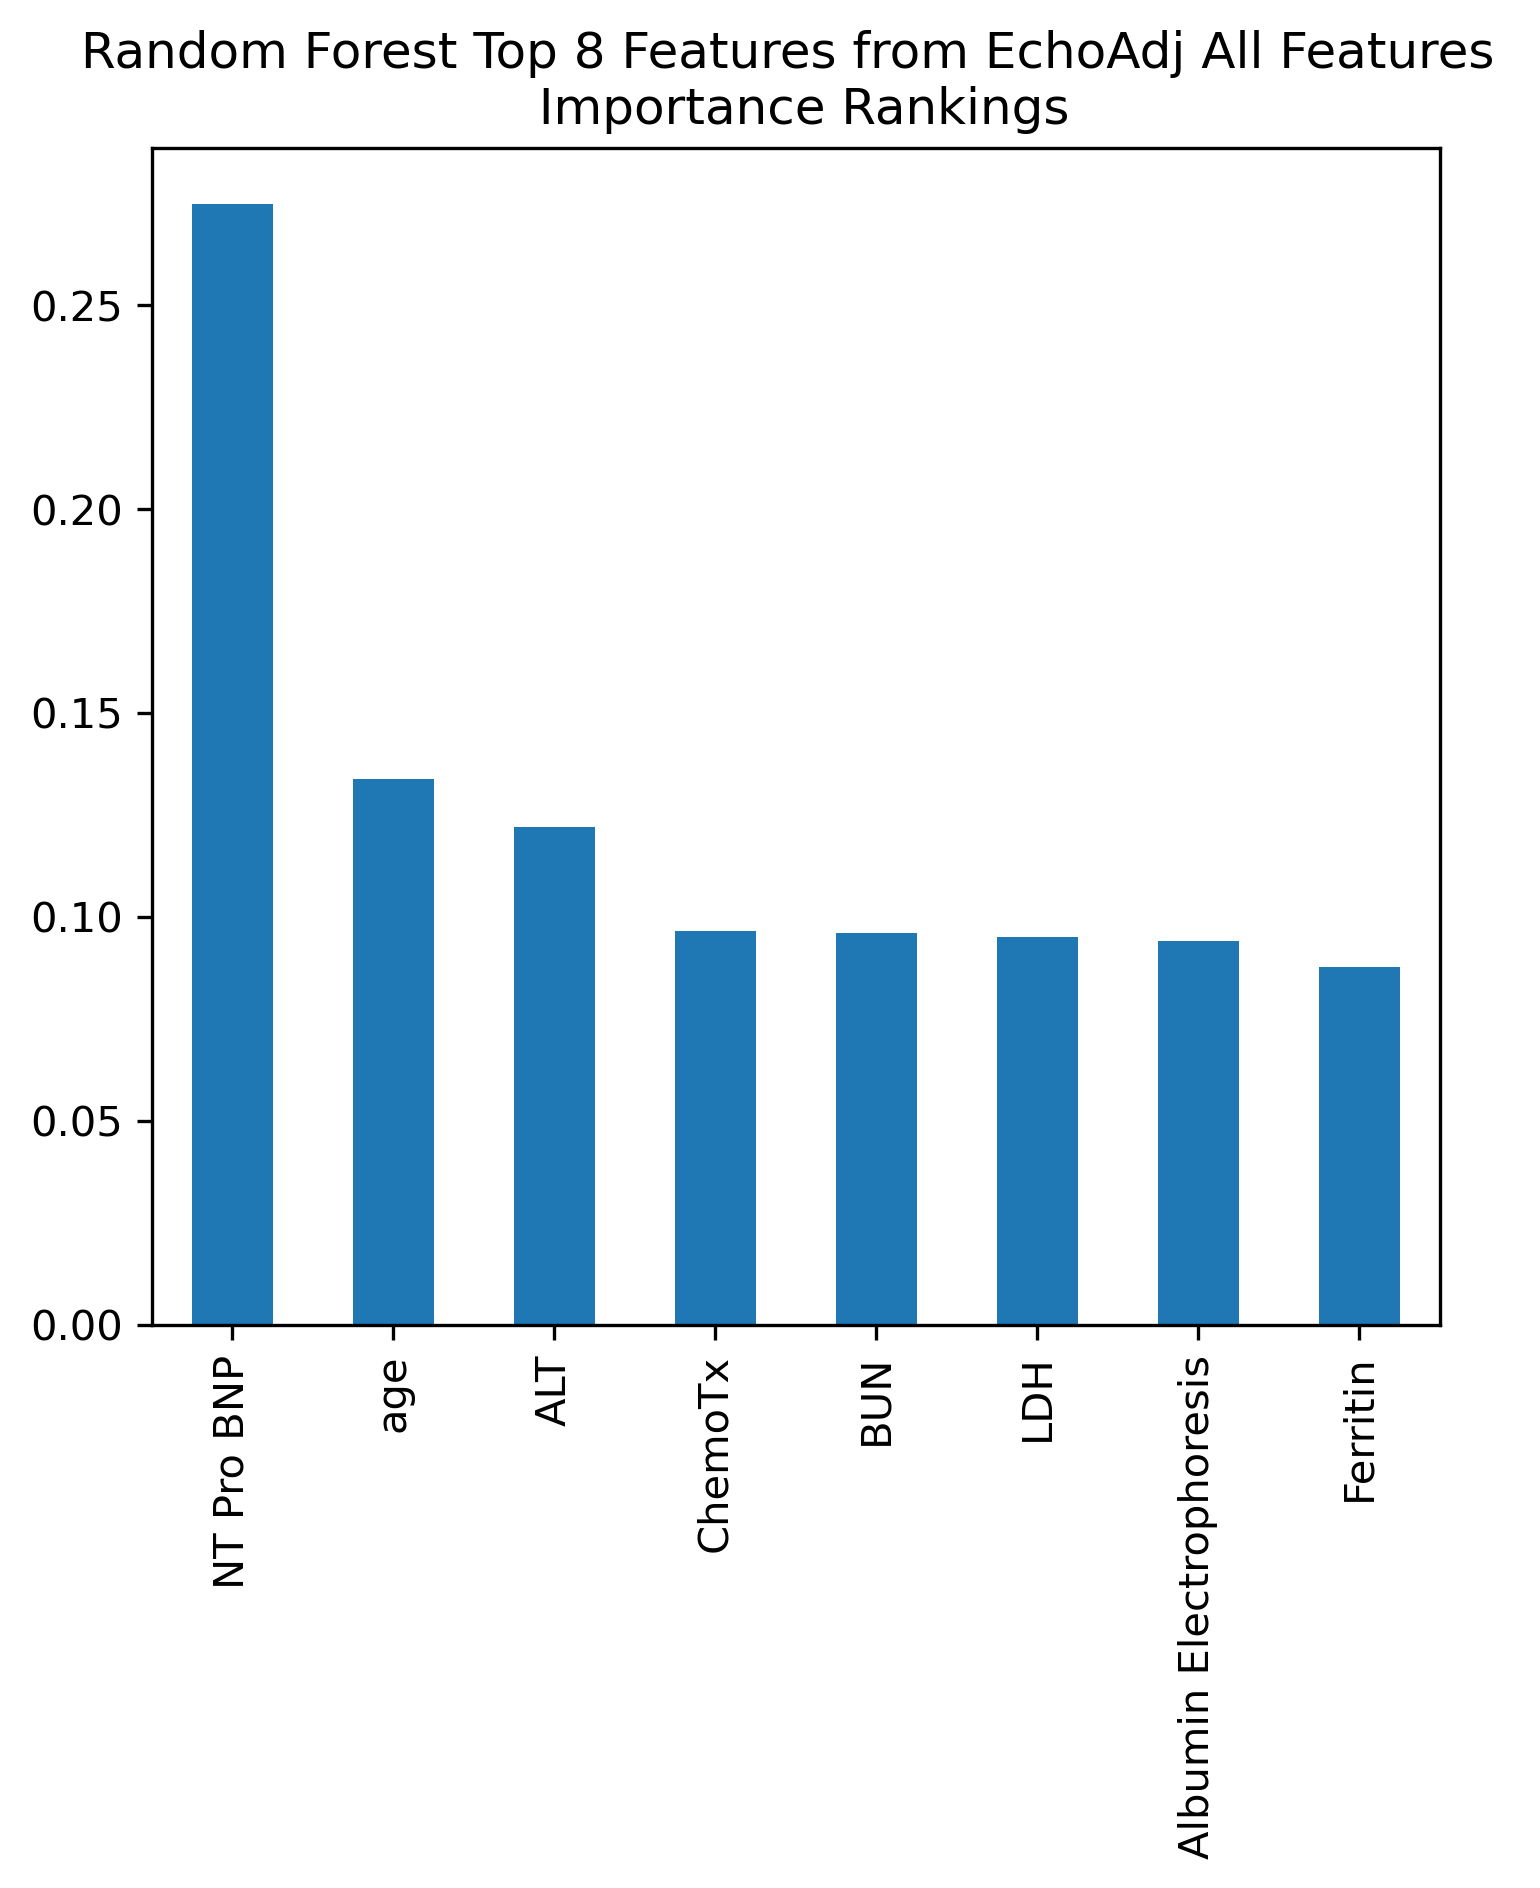

In [82]:
# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest Top 8 Features from EchoAdj All Features \n Importance Rankings")

# Show the plot
plt.show()

In [83]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
# print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print("ROC: ", roc_auc_score(y_test, y_pred))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns)
# fig, ax = plt.subplots()
# xgb_importances.plot.bar(ax=ax)
# ax.set_title("XGBoost All Features Importance Rankings")
# fig.tight_layout()

F1:  0.5454545454545454
ROC:  0.5


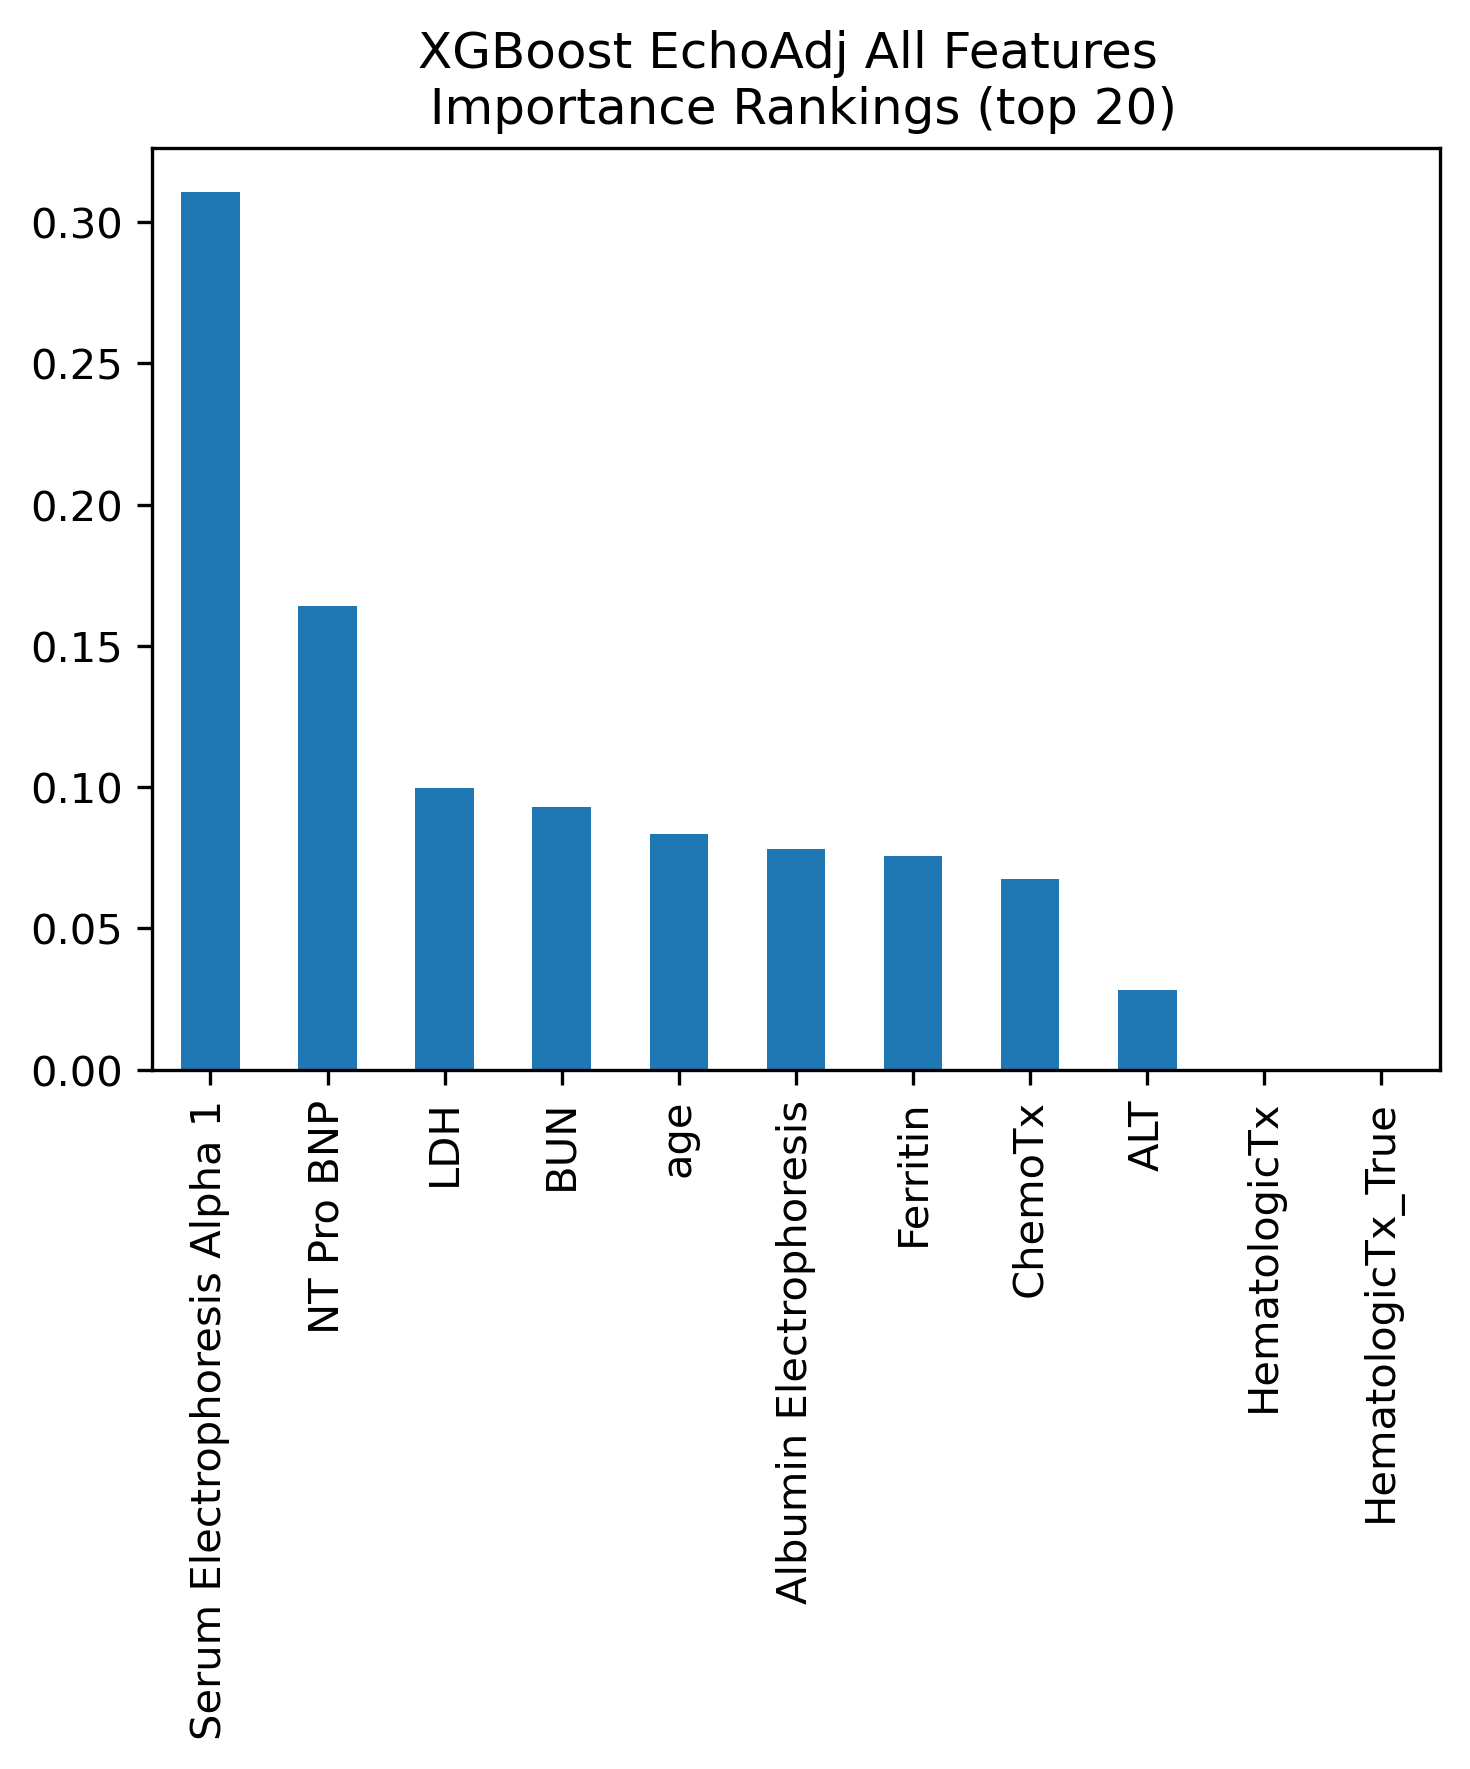

In [84]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = xgb_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("XGBoost EchoAdj All Features \n Importance Rankings (top 20)")
fig.tight_layout()

# Show the plot
plt.show()

In [85]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
# lgb_clf.predict_proba(X_test)
# print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print("ROC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 16, number of negative: 18
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] 

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


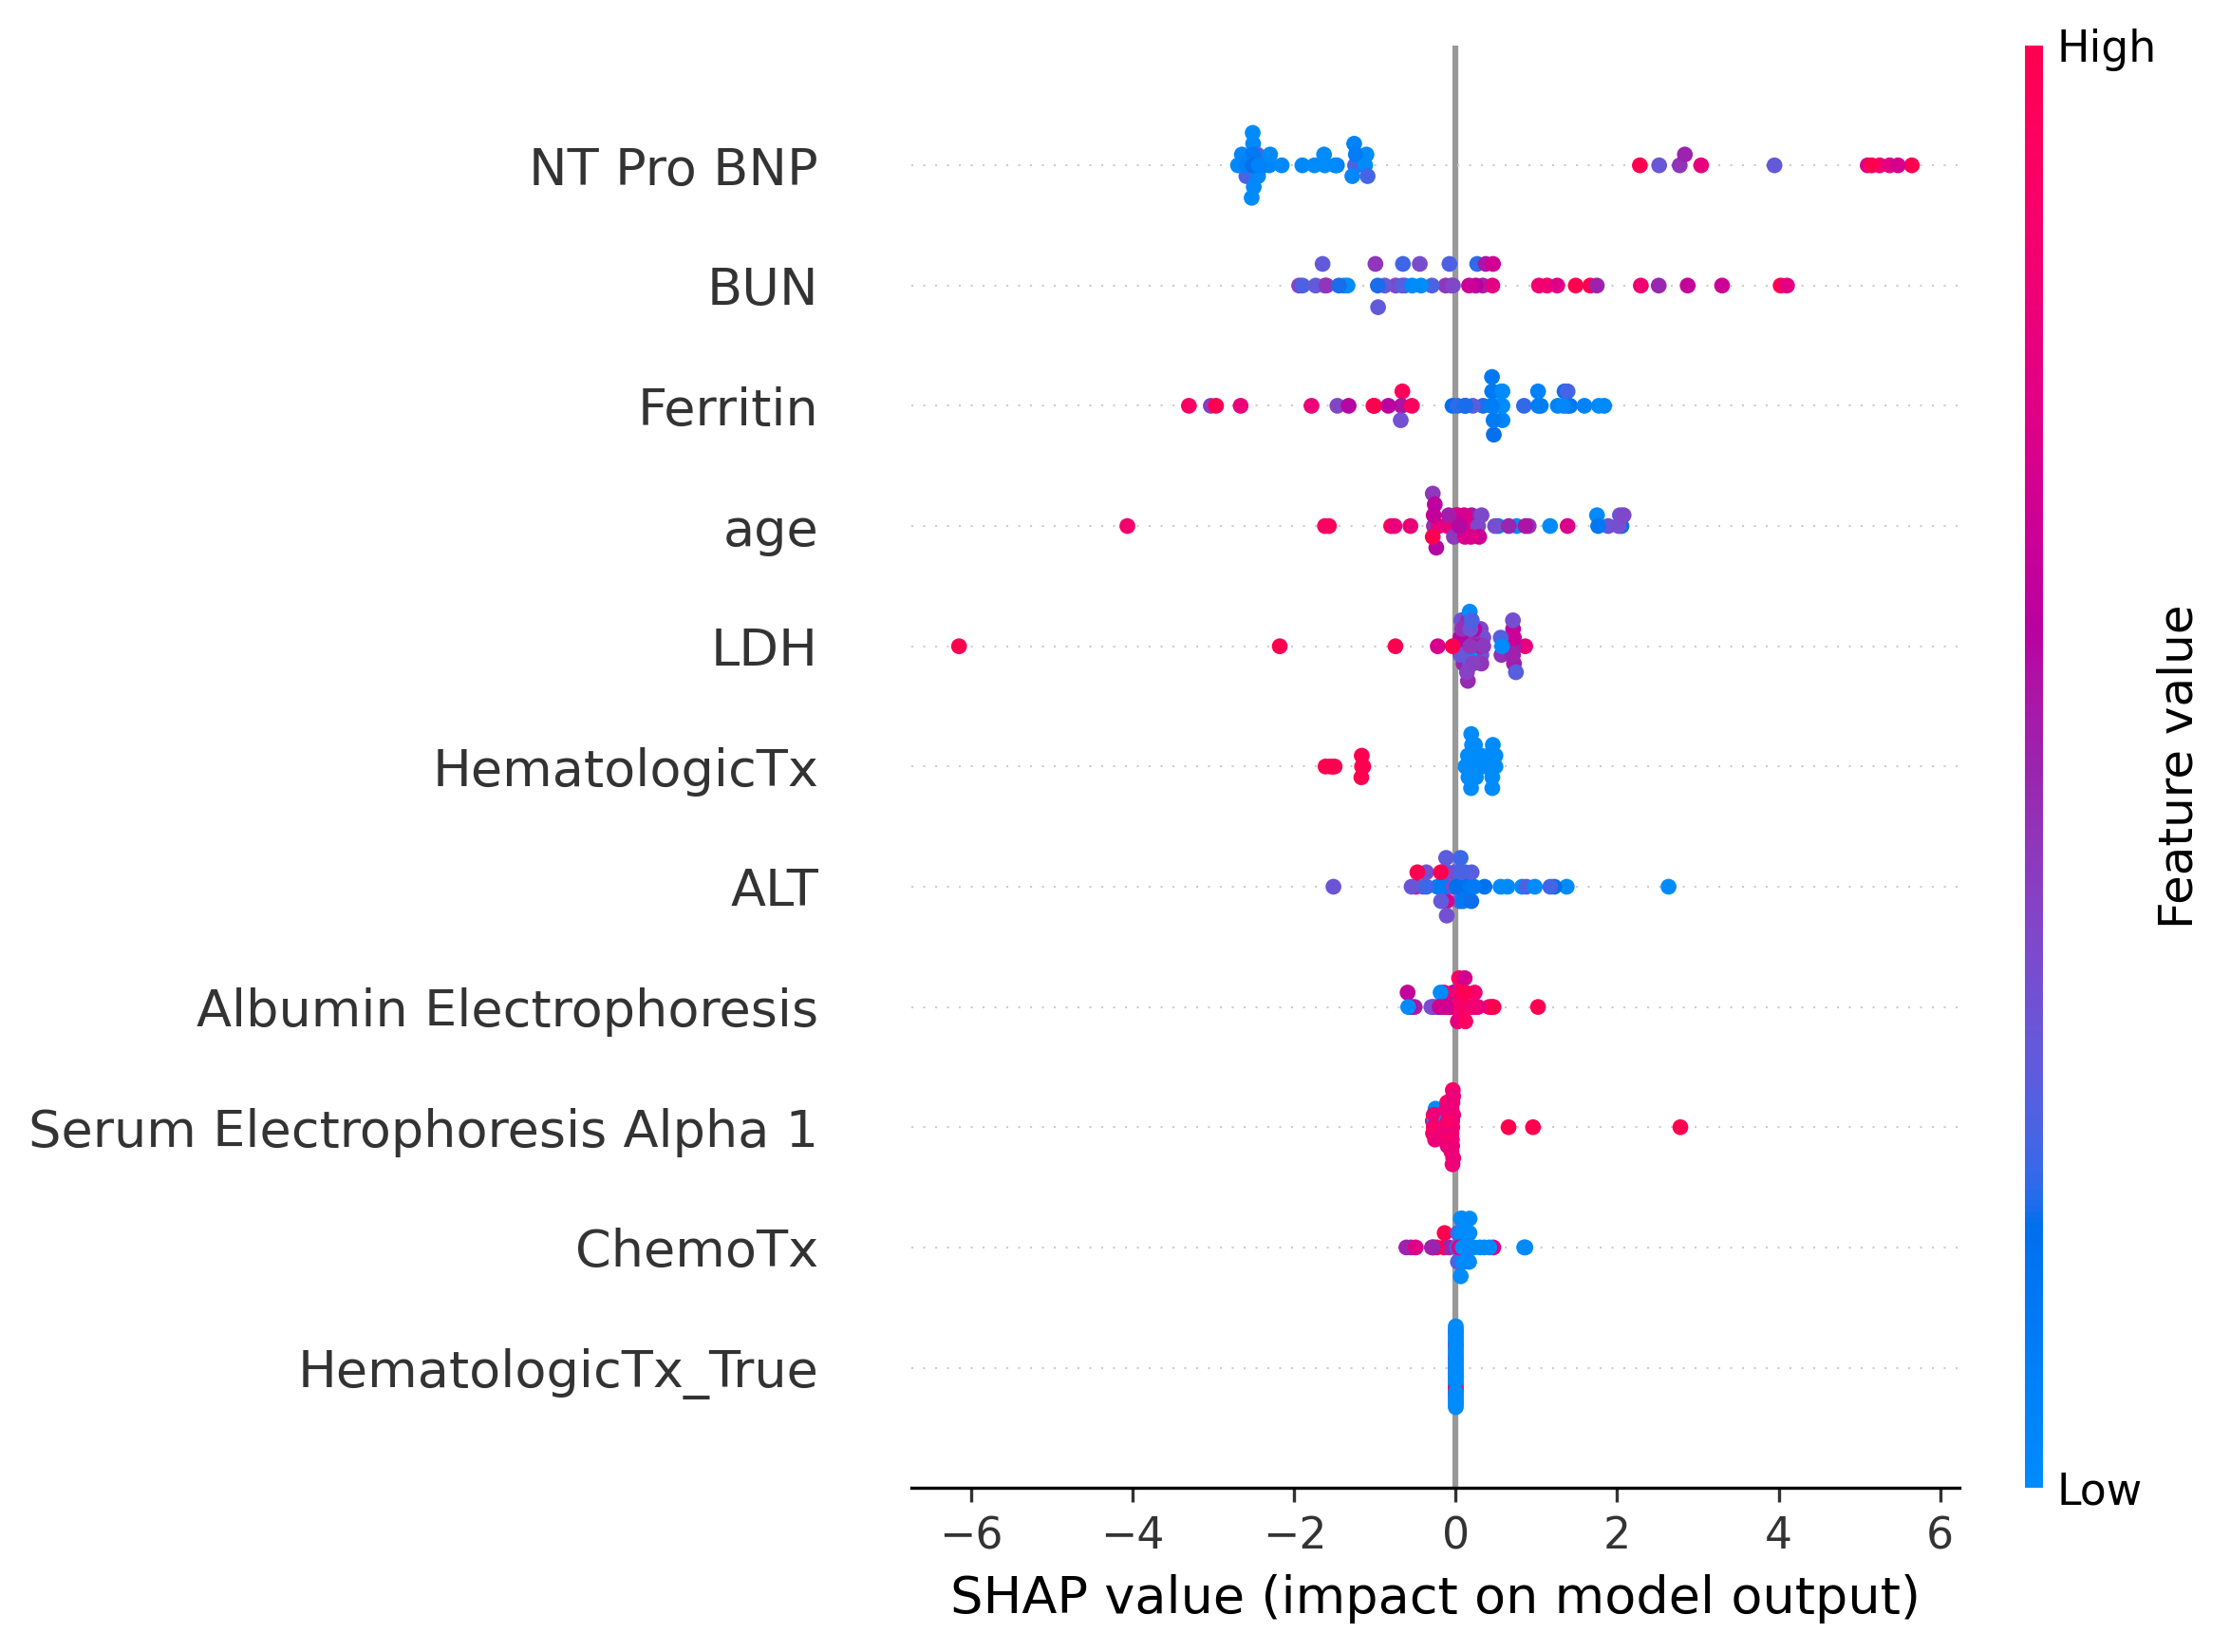

In [86]:
import shap
#borrowed from online source and edited
# create explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names = X.columns)


# bar plot for feature importances
# shap.summary_plot(shap_values_reshaped[1], X_test, plot_type="bar")

# Show the plot
plt.show()

# feature selection

In [87]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 11, Score: 0.877
Number of Features: 10, Score: 0.725
Number of Features: 9, Score: 0.696
Number of Features: 8, Score: 0.749
Number of Features: 7, Score: 0.768
Number of Features: 6, Score: 0.788
Number of Features: 5, Score: 0.788
Number of Features: 4, Score: 0.744
Number of Features: 3, Score: 0.267
Number of Features: 2, Score: 0.244
Number of Features: 1, Score: 0.257
Rank weight: 0.15
Number of Features: 11, Score: 0.877
Number of Features: 10, Score: 0.725
Number of Features: 9, Score: 0.696
Number of Features: 8, Score: 0.725
Number of Features: 7, Score: 0.553
Number of Features: 6, Score: 0.645
Number of Features: 5, Score: 0.688
Number of Features: 4, Score: 0.694
Number of Features: 3, Score: 0.664
Number of Features: 2, Score: 0.656
Number of Features: 1, Score: 0.257
Rank weight: 0.20
Number of Features: 11, Score: 0.877
Number of Features: 10, Score: 0.725
Number of Features: 9, Score: 0.696
Number of Features: 8, Score: 0.725
Numb

# Performance plots

## F1 and AUC plots

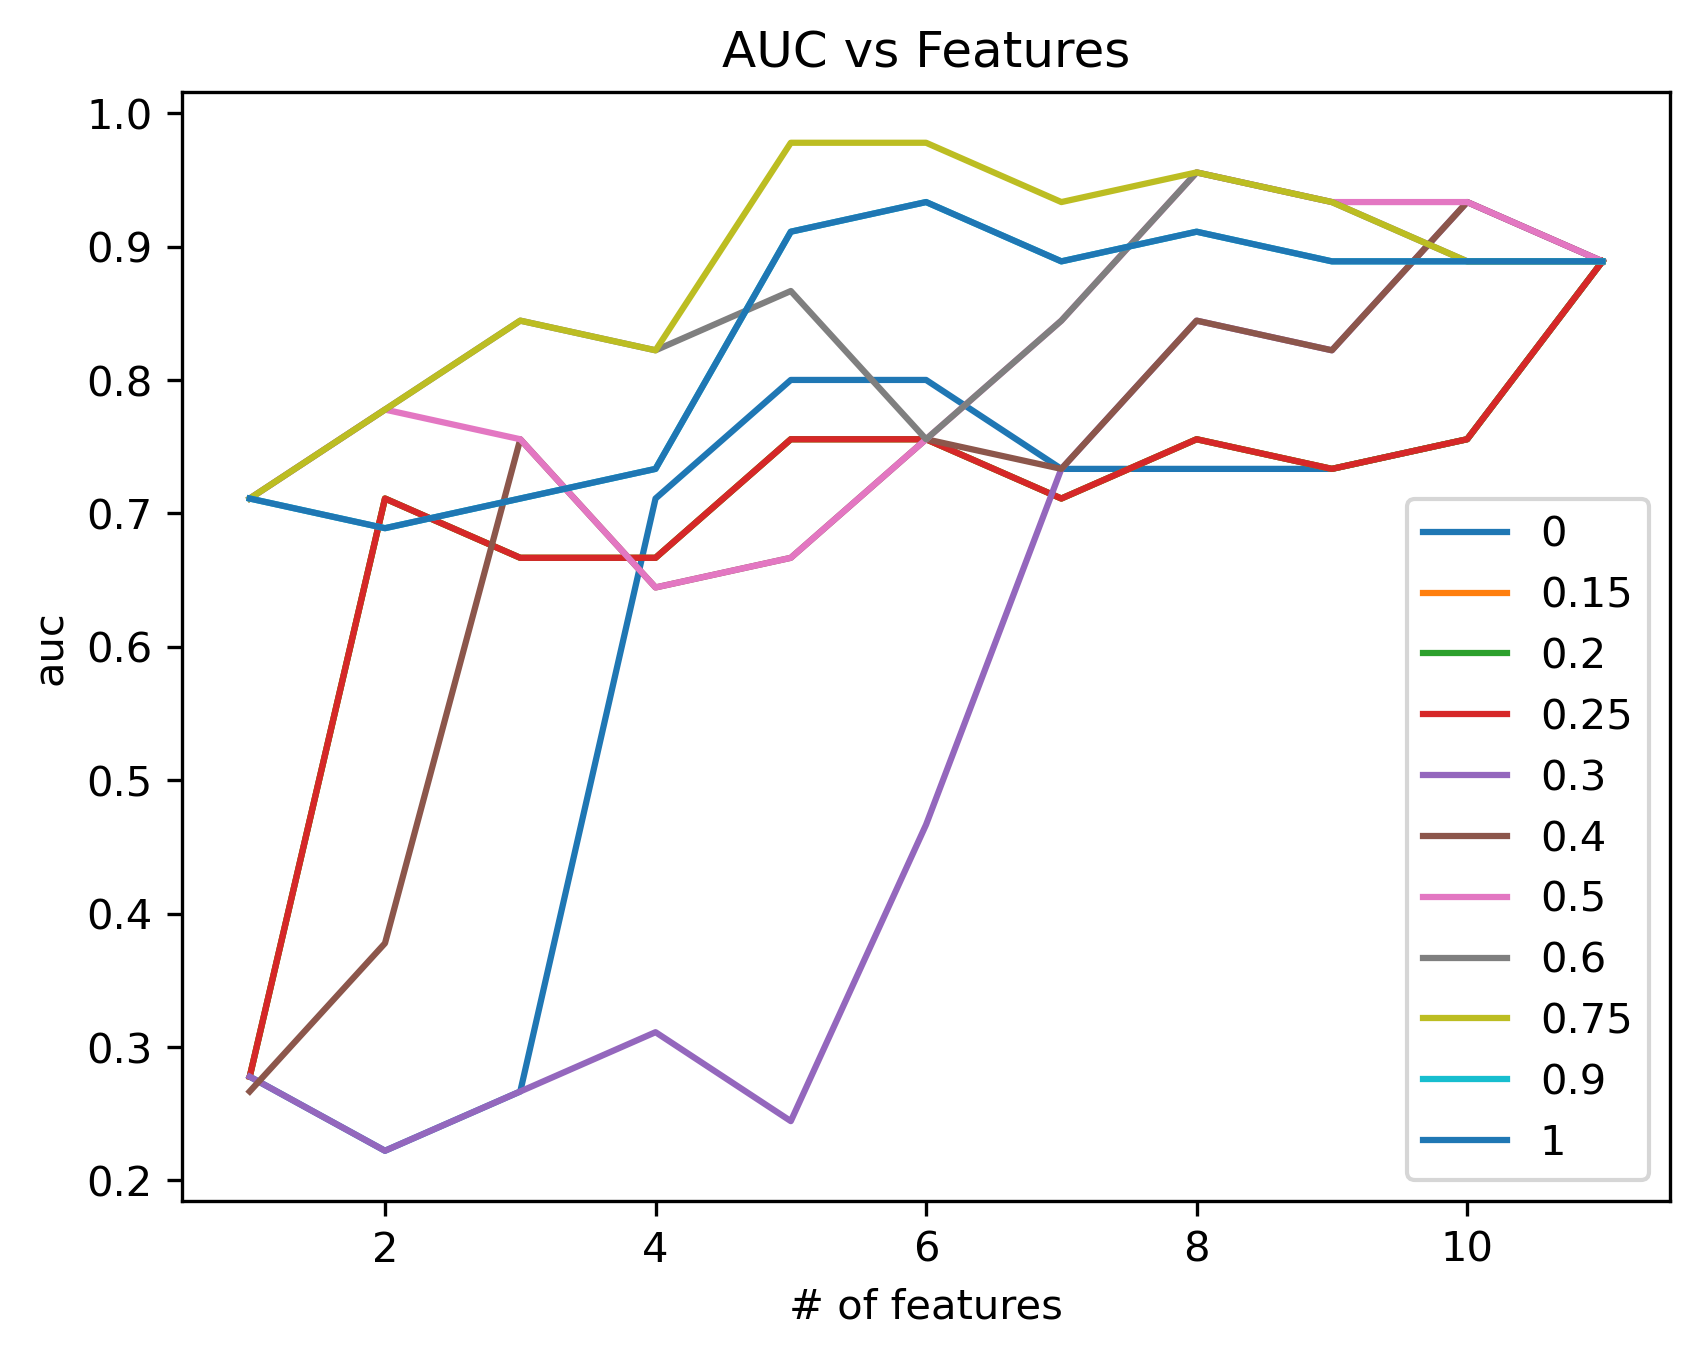

In [88]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

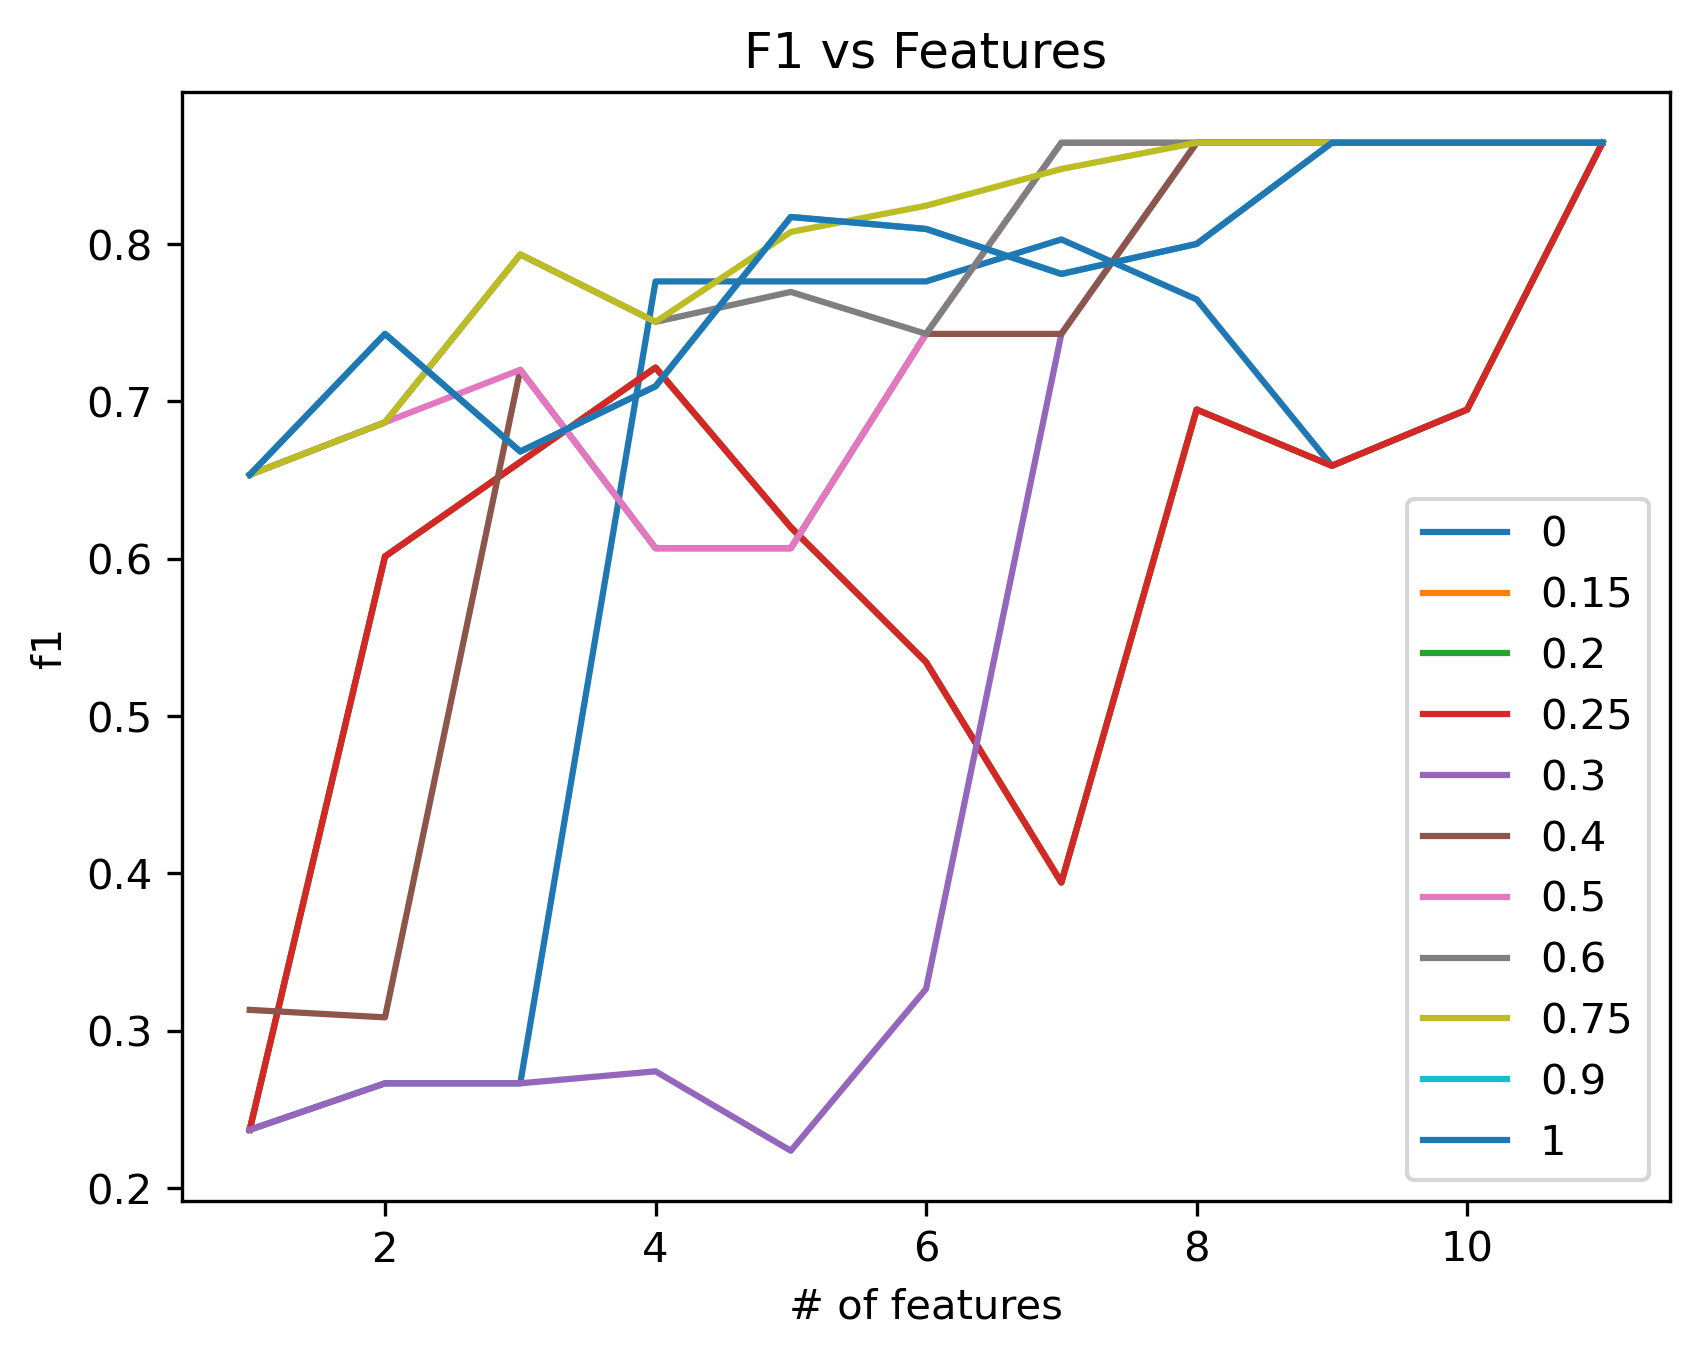

In [89]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

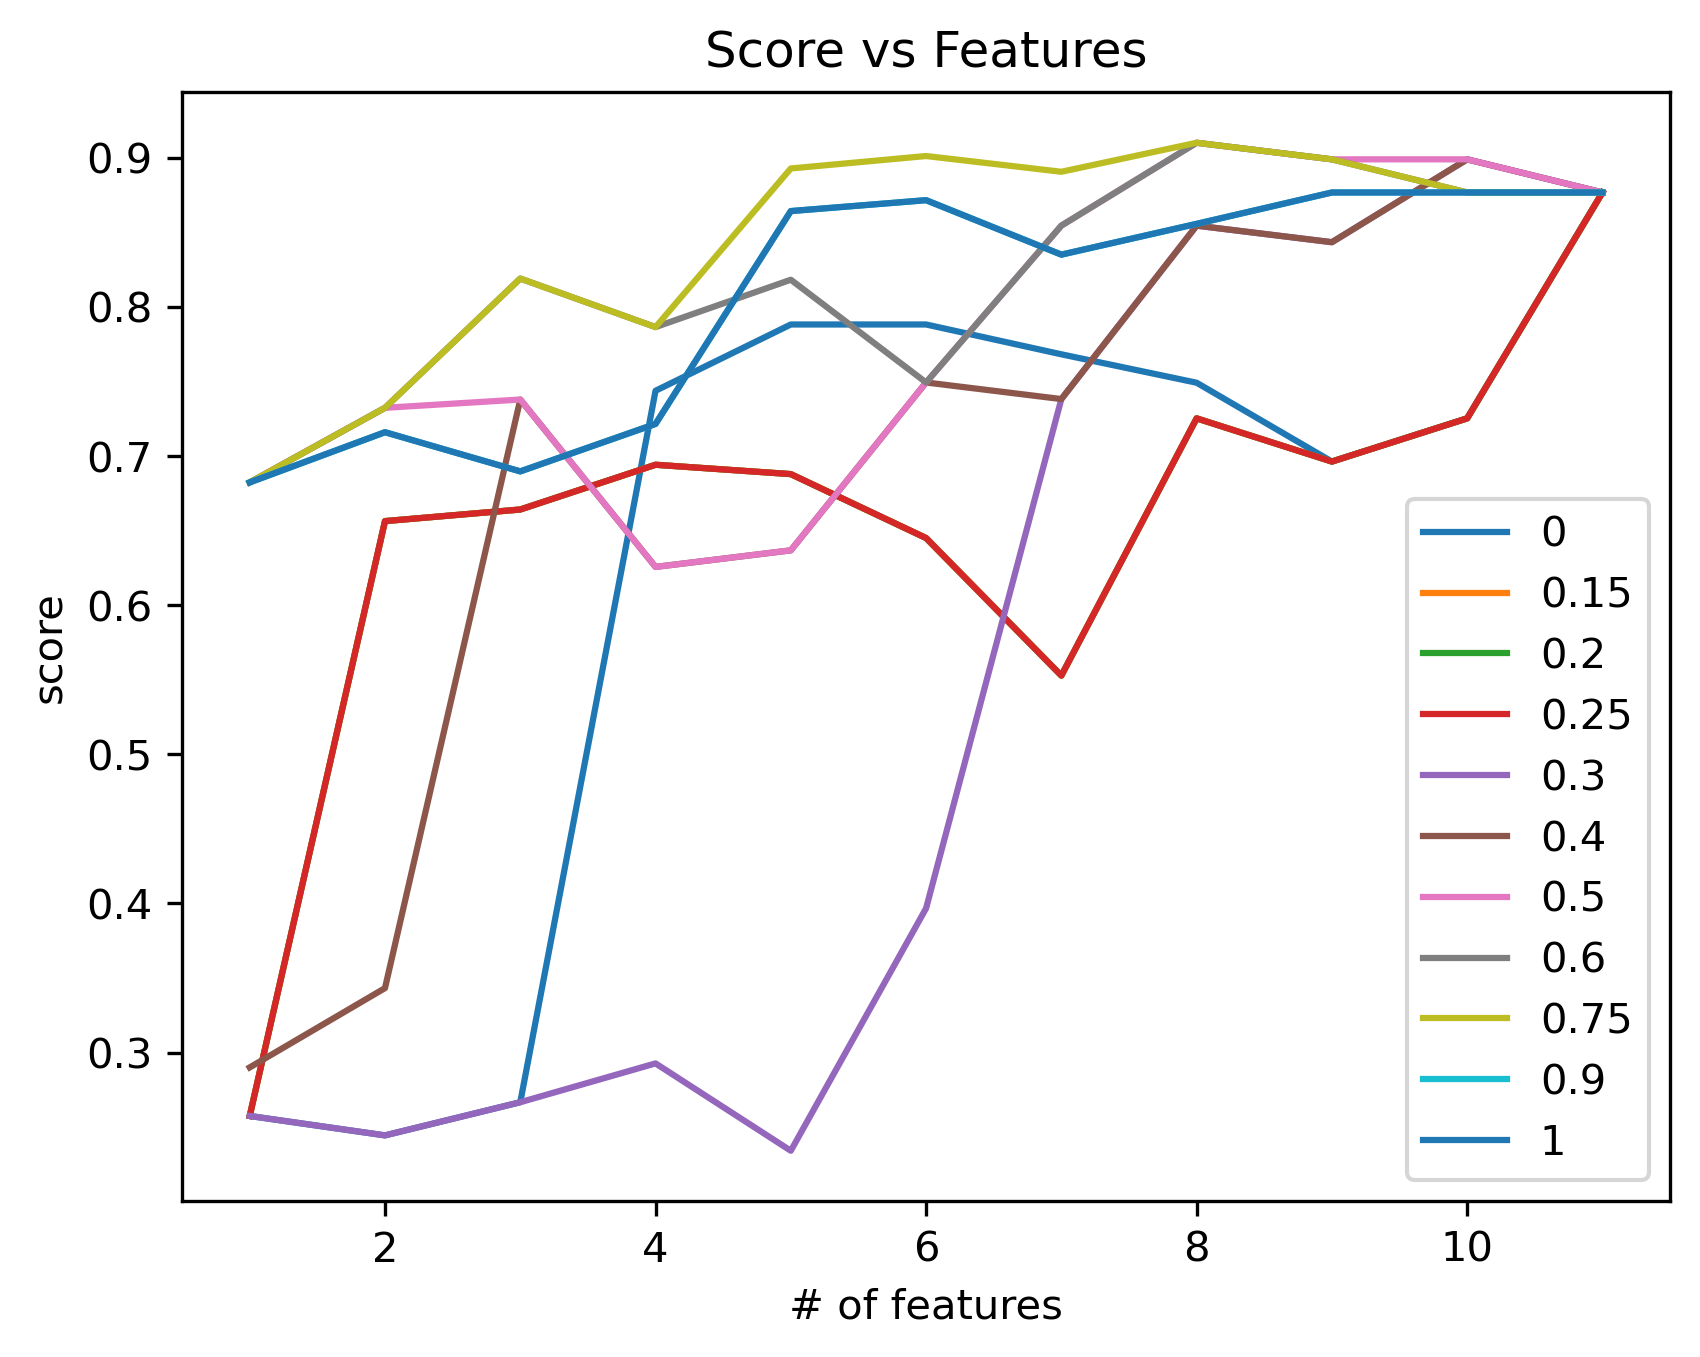

In [90]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

In [91]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.5760425685425686,
 0.6012085137085137,
 0.6012085137085137,
 0.6012085137085137,
 0.48510461760461765,
 0.6372907647907649,
 0.7111580086580087,
 0.7476226551226552,
 0.7714898989898991,
 0.7350468975468974,
 0.7350468975468974]

In [92]:
svm_set_ranks[selected_run].performance_

{'f1': 0.8642857142857142,
 'auc': 0.9555555555555555,
 'score': 0.909920634920635,
 'C': 2,
 'num_features': 8,
 'mean_nSV': 11.4}

In [93]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [94]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [95]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [96]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0     0.250000  0.44       3.0        2.0        4.0       1.0   
0.15  0.250000  0.44       3.0        2.0        4.0       1.0   
0.2   0.250000  0.44       3.0        2.0        4.0       1.0   
0.25  0.250000  0.44       3.0        2.0        4.0       1.0   
0.3   0.444444  0.52       3.0        2.0        3.0       2.0   
0.4   0.444444  0.52       3.0        2.0        3.0       2.0   
0.5   0.444444  0.52       3.0        2.0        3.0       2.0   
0.6   0.444444  0.52       3.0        2.0        3.0       2.0   
0.75  0.444444  0.52       3.0        2.0        3.0       2.0   
0.9   0.250000  0.52       3.0        2.0        4.0       1.0   
1     0.250000  0.52       3.0        2.0        4.0       1.0   

      precision or PPV  recall or TPR  specificity or TNR  
0             0.333333            0.2                 0.6  
0.15          0.333333            0.2                 0.6  
0.2           0.333333            0.2                 0.6  
0.25          0.333333            0.2                 0.6  
0.3           0.500000            0.4                 0.6  
0.4           0.500000            0.4                 0.6  
0.5           0.500000            0.4                 0.6  
0.6           0.500000            0.4                 0.6  
0.75          0.500000            0.4                 0.6  
0.9           0.333333            0.2                 0.6  
1             0.333333            0.2                 0.6

In [97]:
df_performance

f1       auc     score    C  num_features  mean_nSV
0     0.864286  0.888889  0.876587  1.0          11.0      12.6
0.15  0.864286  0.888889  0.876587  1.0          11.0      12.6
0.2   0.864286  0.888889  0.876587  1.0          11.0      12.6
0.25  0.864286  0.888889  0.876587  1.0          11.0      12.6
0.3   0.864286  0.933333  0.898810  1.0          10.0      12.8
0.4   0.864286  0.933333  0.898810  1.0          10.0      12.8
0.5   0.864286  0.955556  0.909921  2.0           8.0      11.4
0.6   0.864286  0.955556  0.909921  2.0           8.0      11.4
0.75  0.864286  0.955556  0.909921  2.0           8.0      11.4
0.9   0.864286  0.888889  0.876587  1.0           9.0      12.4
1     0.864286  0.888889  0.876587  1.0           9.0      12.4

In [98]:
df_features

0                           0.15  \
0                             age                            age   
1                         ChemoTx                        ChemoTx   
2                   HematologicTx                  HematologicTx   
3              HematologicTx_True             HematologicTx_True   
4                             ALT                            ALT   
5         Albumin Electrophoresis        Albumin Electrophoresis   
6                             BUN                            BUN   
7                        Ferritin                       Ferritin   
8                             LDH                            LDH   
9   Serum Electrophoresis Alpha 1  Serum Electrophoresis Alpha 1   
10                     NT Pro BNP                     NT Pro BNP   

                              0.2                           0.25  \
0                             age                            age   
1                         ChemoTx                        ChemoTx   
2                   HematologicTx                  HematologicTx   
3              HematologicTx_True             HematologicTx_True   
4                             ALT                            ALT   
5         Albumin Electrophoresis        Albumin Electrophoresis   
6                             BUN                            BUN   
7                        Ferritin                       Ferritin   
8                             LDH                            LDH   
9   Serum Electrophoresis Alpha 1  Serum Electrophoresis Alpha 1   
10                     NT Pro BNP                     NT Pro BNP   

                              0.3                            0.4  \
0                             age                            age   
1                   HematologicTx                  HematologicTx   
2              HematologicTx_True             HematologicTx_True   
3                             ALT                            ALT   
4         Albumin Electrophoresis        Albumin Electrophoresis   
5                             BUN                            BUN   
6                        Ferritin                       Ferritin   
7                             LDH                            LDH   
8   Serum Electrophoresis Alpha 1  Serum Electrophoresis Alpha 1   
9                      NT Pro BNP                     NT Pro BNP   
10                            NaN                            NaN   

                              0.5                            0.6  \
0                             age                            age   
1              HematologicTx_True                  HematologicTx   
2                             ALT                            ALT   
3                             BUN                            BUN   
4                        Ferritin                       Ferritin   
5                             LDH                            LDH   
6   Serum Electrophoresis Alpha 1  Serum Electrophoresis Alpha 1   
7                      NT Pro BNP                     NT Pro BNP   
8                             NaN                            NaN   
9                             NaN                            NaN   
10                            NaN                            NaN   

                             0.75                            0.9  \
0                             age                            age   
1                   HematologicTx                        ChemoTx   
2                             ALT                  HematologicTx   
3                             BUN                            ALT   
4                        Ferritin                            BUN   
5                             LDH                       Ferritin   
6   Serum Electrophoresis Alpha 1                            LDH   
7                      NT Pro BNP  Serum Electrophoresis Alpha 1   
8                             NaN                     NT Pro BNP   
9                             NaN                            NaN   
10              

## best model performance

In [99]:
print("rank weights: ", str(rank_weights[selected_run]))
print(df_performance.iloc[selected_run])
print(df_blindprediction.iloc[selected_run])

rank weights:  0.75
f1               0.864286
auc              0.955556
score            0.909921
C                2.000000
num_features     8.000000
mean_nSV        11.400000
Name: 0.75, dtype: float64
f1                    0.444444
auc                   0.520000
true neg              3.000000
false pos             2.000000
false neg             3.000000
true pos              2.000000
precision or PPV      0.500000
recall or TPR         0.400000
specificity or TNR    0.600000
Name: 0.75, dtype: float64


In [100]:
df_features[str(rank_weights[selected_run])].dropna()

0                              age
1                    HematologicTx
2                              ALT
3                              BUN
4                         Ferritin
5                              LDH
6    Serum Electrophoresis Alpha 1
7                       NT Pro BNP
Name: 0.75, dtype: object

## pair plots

In [101]:
X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values

array(['NT Pro BNP', 'Serum Electrophoresis Alpha 1', 'age', 'LDH',
       'HematologicTx', 'Ferritin', 'BUN', 'ALT'], dtype=object)

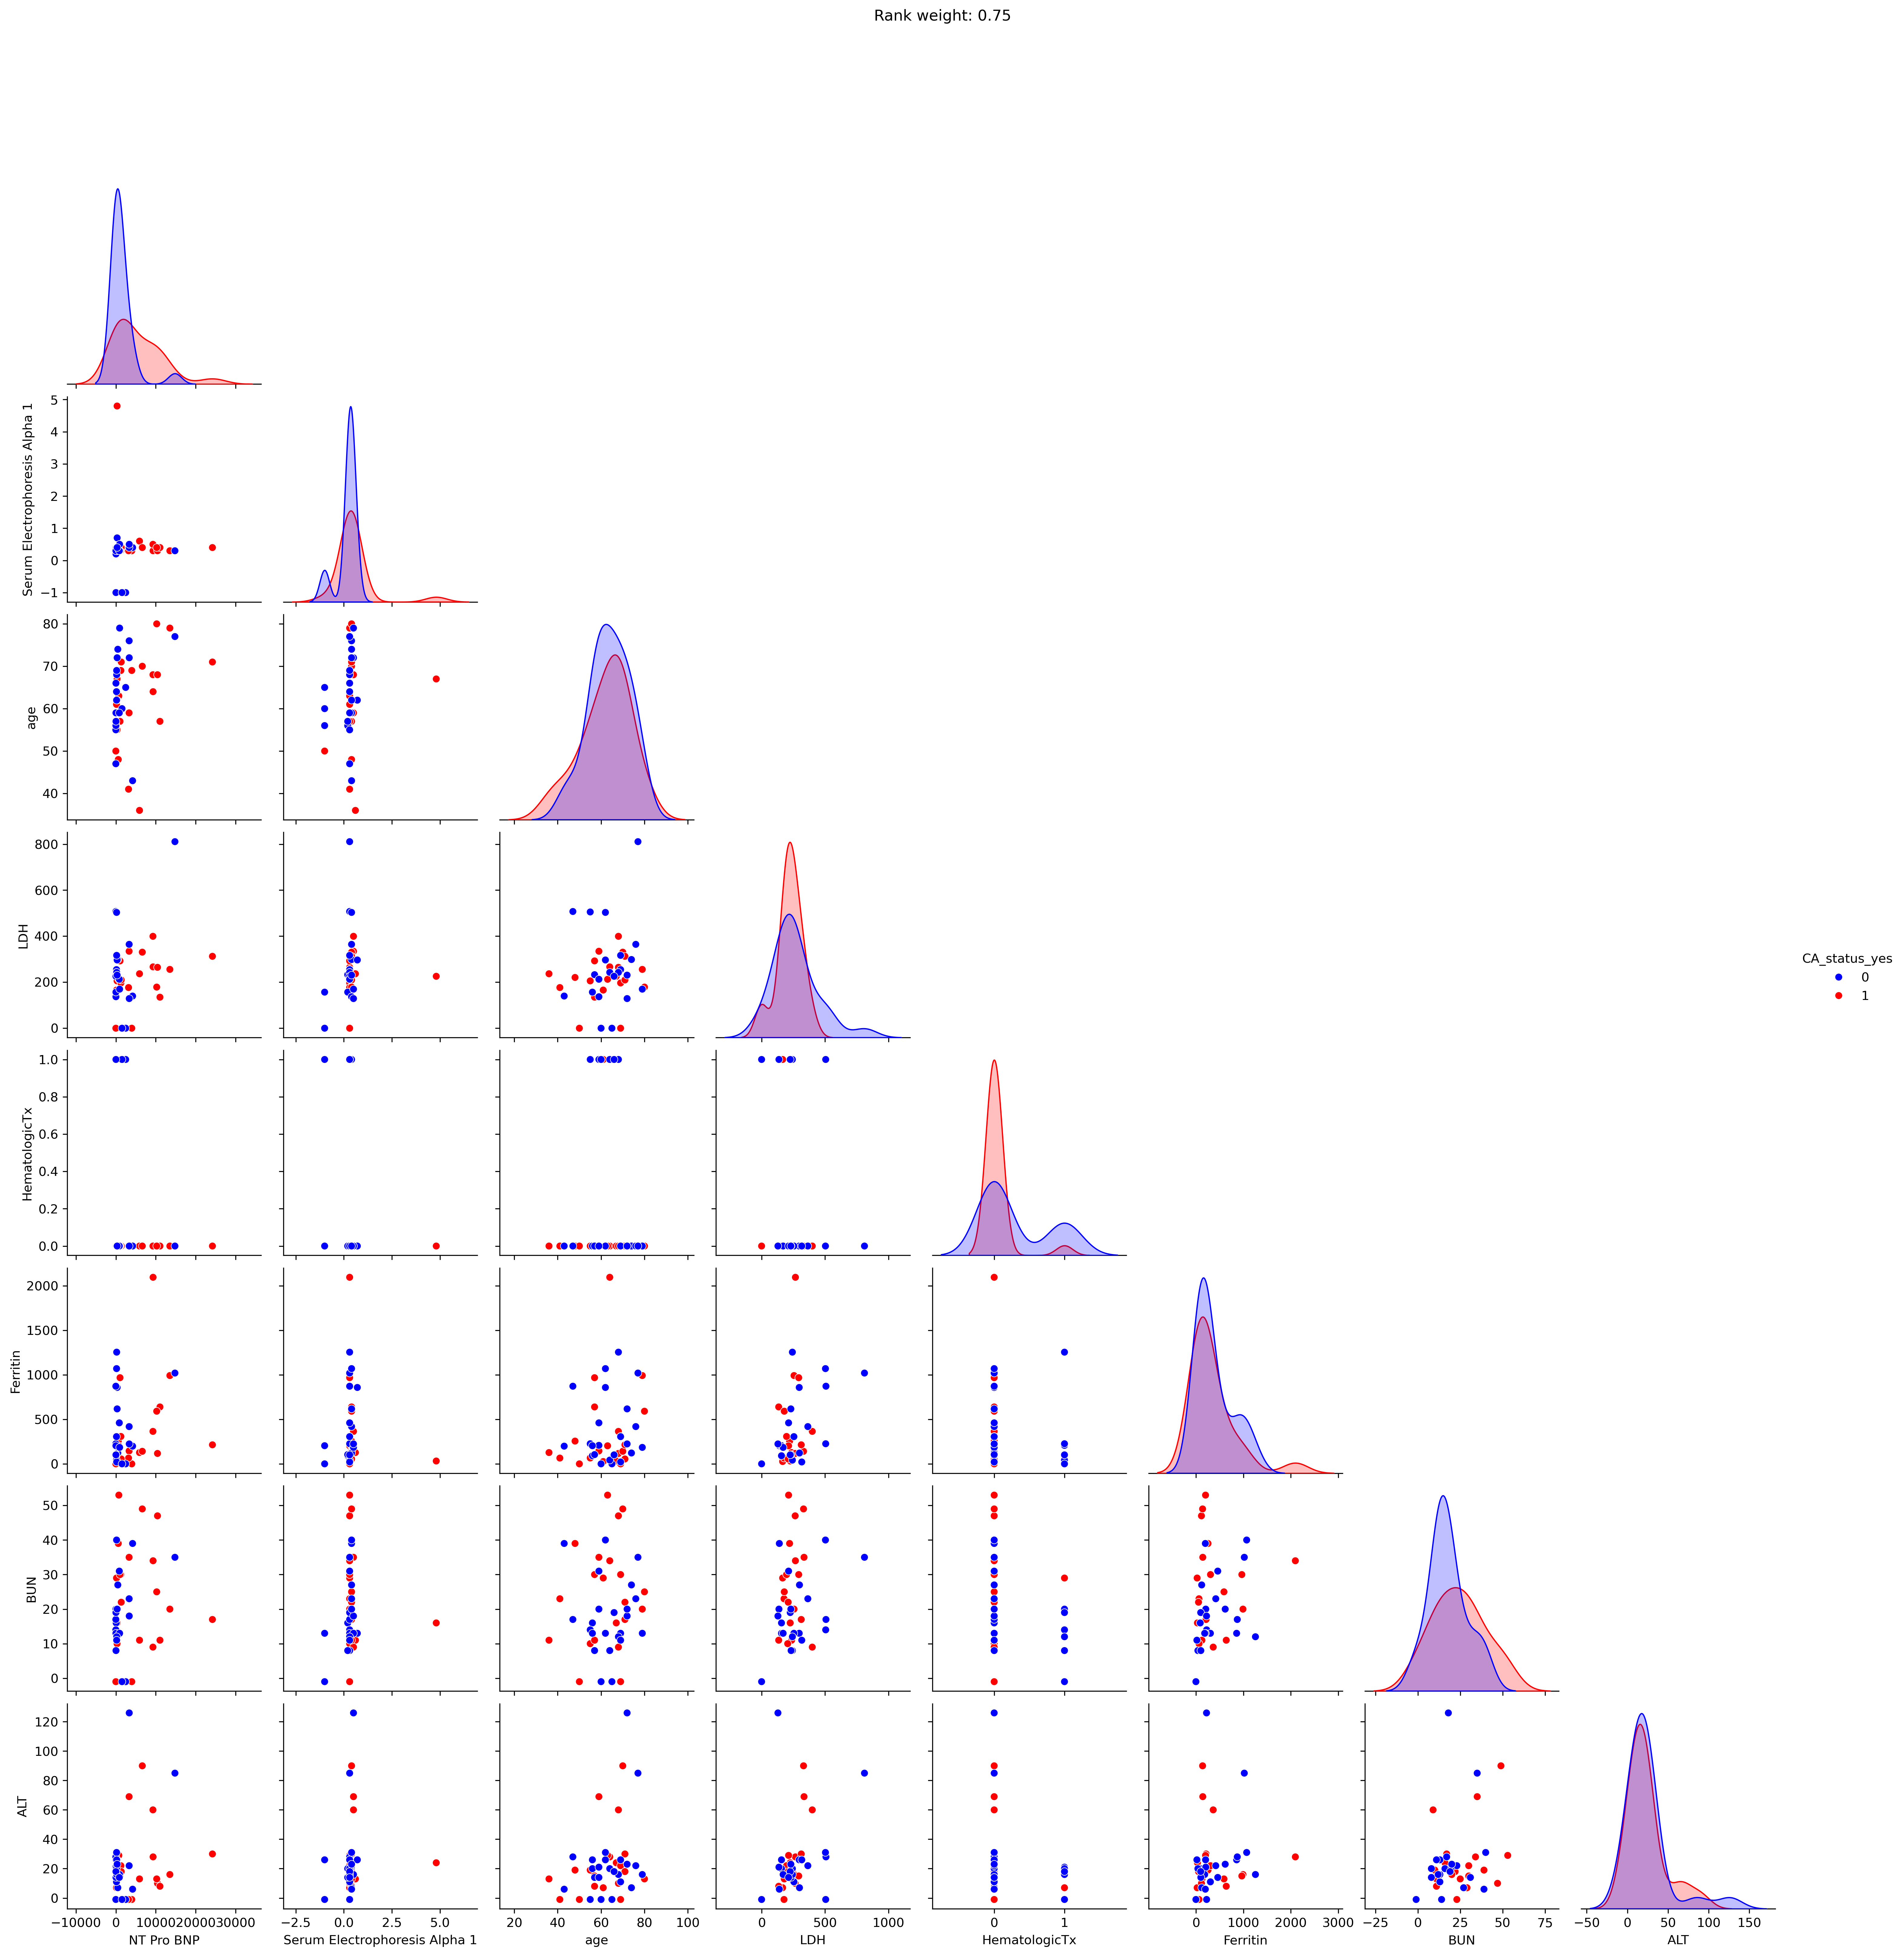

In [103]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

#saving figure
figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

In [104]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [105]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



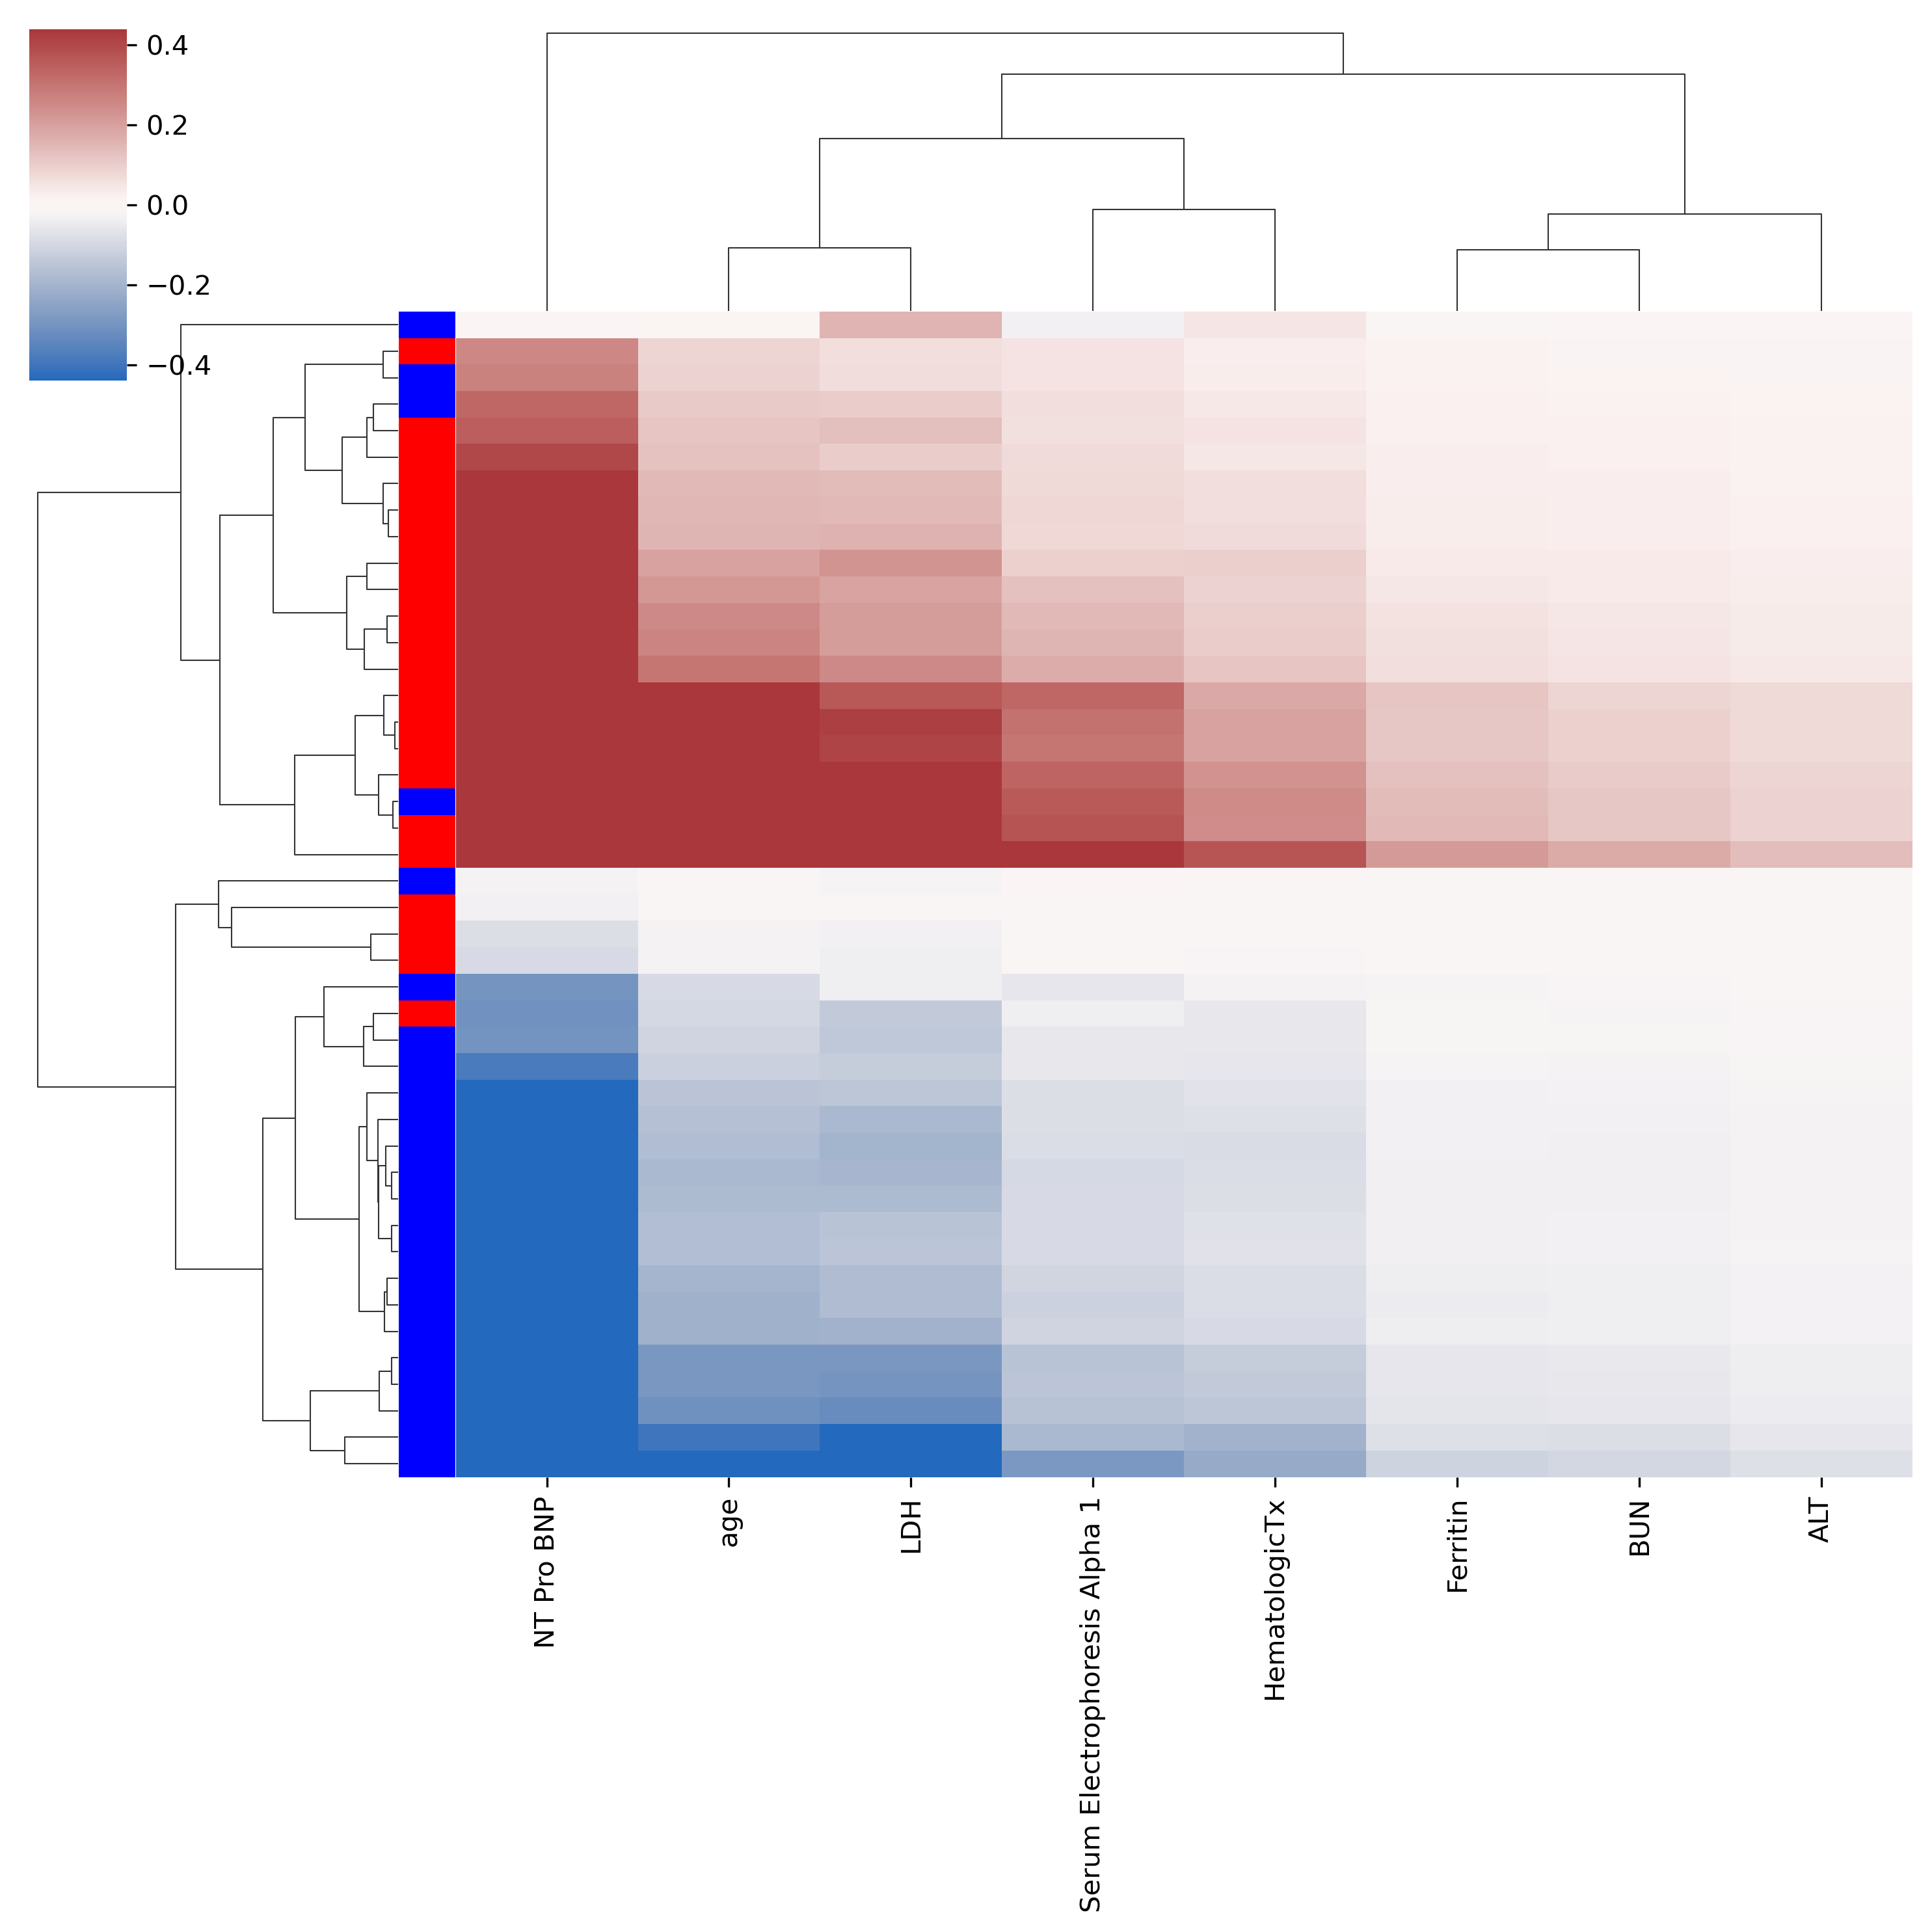

In [106]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

In [107]:
X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values

array(['NT Pro BNP', 'Serum Electrophoresis Alpha 1', 'age', 'LDH',
       'HematologicTx', 'Ferritin', 'BUN', 'ALT'], dtype=object)

In [108]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=600,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [109]:
nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=2000,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [110]:
feat_1 = IGtable.columns[feature_order[0]]
feat_2 = IGtable.columns[feature_order[1]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

In [111]:
# feat_1 = IGtable.columns[feature_order[5]]
# feat_2 = IGtable.columns[feature_order[6]]

# fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
# fig.update_traces(marker=dict(size=12))

# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=800,
#     height=800,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = feat_1,
#     yaxis_title = "Integrated Gradient for " + feat_1,
#     font=dict(size=20)
# )

# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
#     )
    
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
# )

# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text=feat_2,side = "right"),
#                     cmin = -1, cmax = 1)

# fig.show()

# sensitivity and specificity 

In [112]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

True Negative:  3
false positive:  2
false negative:  3
true positive:  2
true positive rate or recall/sensitivity:  0.4
positive predictive value or precision:  0.5
specificity or true negatie rate:  0.6
auc:  0.52
f1 score:  0.4444444444444445


# testing alt models on best feature list

In [113]:
X_all_trim = X_all[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_train_trim = X_train[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_test_trim = X_test[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
#making the dataset only include the features from the best performing model in SVM

In [114]:
cv_set_trim = cvSet(X = X_train_trim, y = y_train.values)
cv_set_trim.classification(num_sets = numb_sets)

F1:  0.0
ROC:  0.4


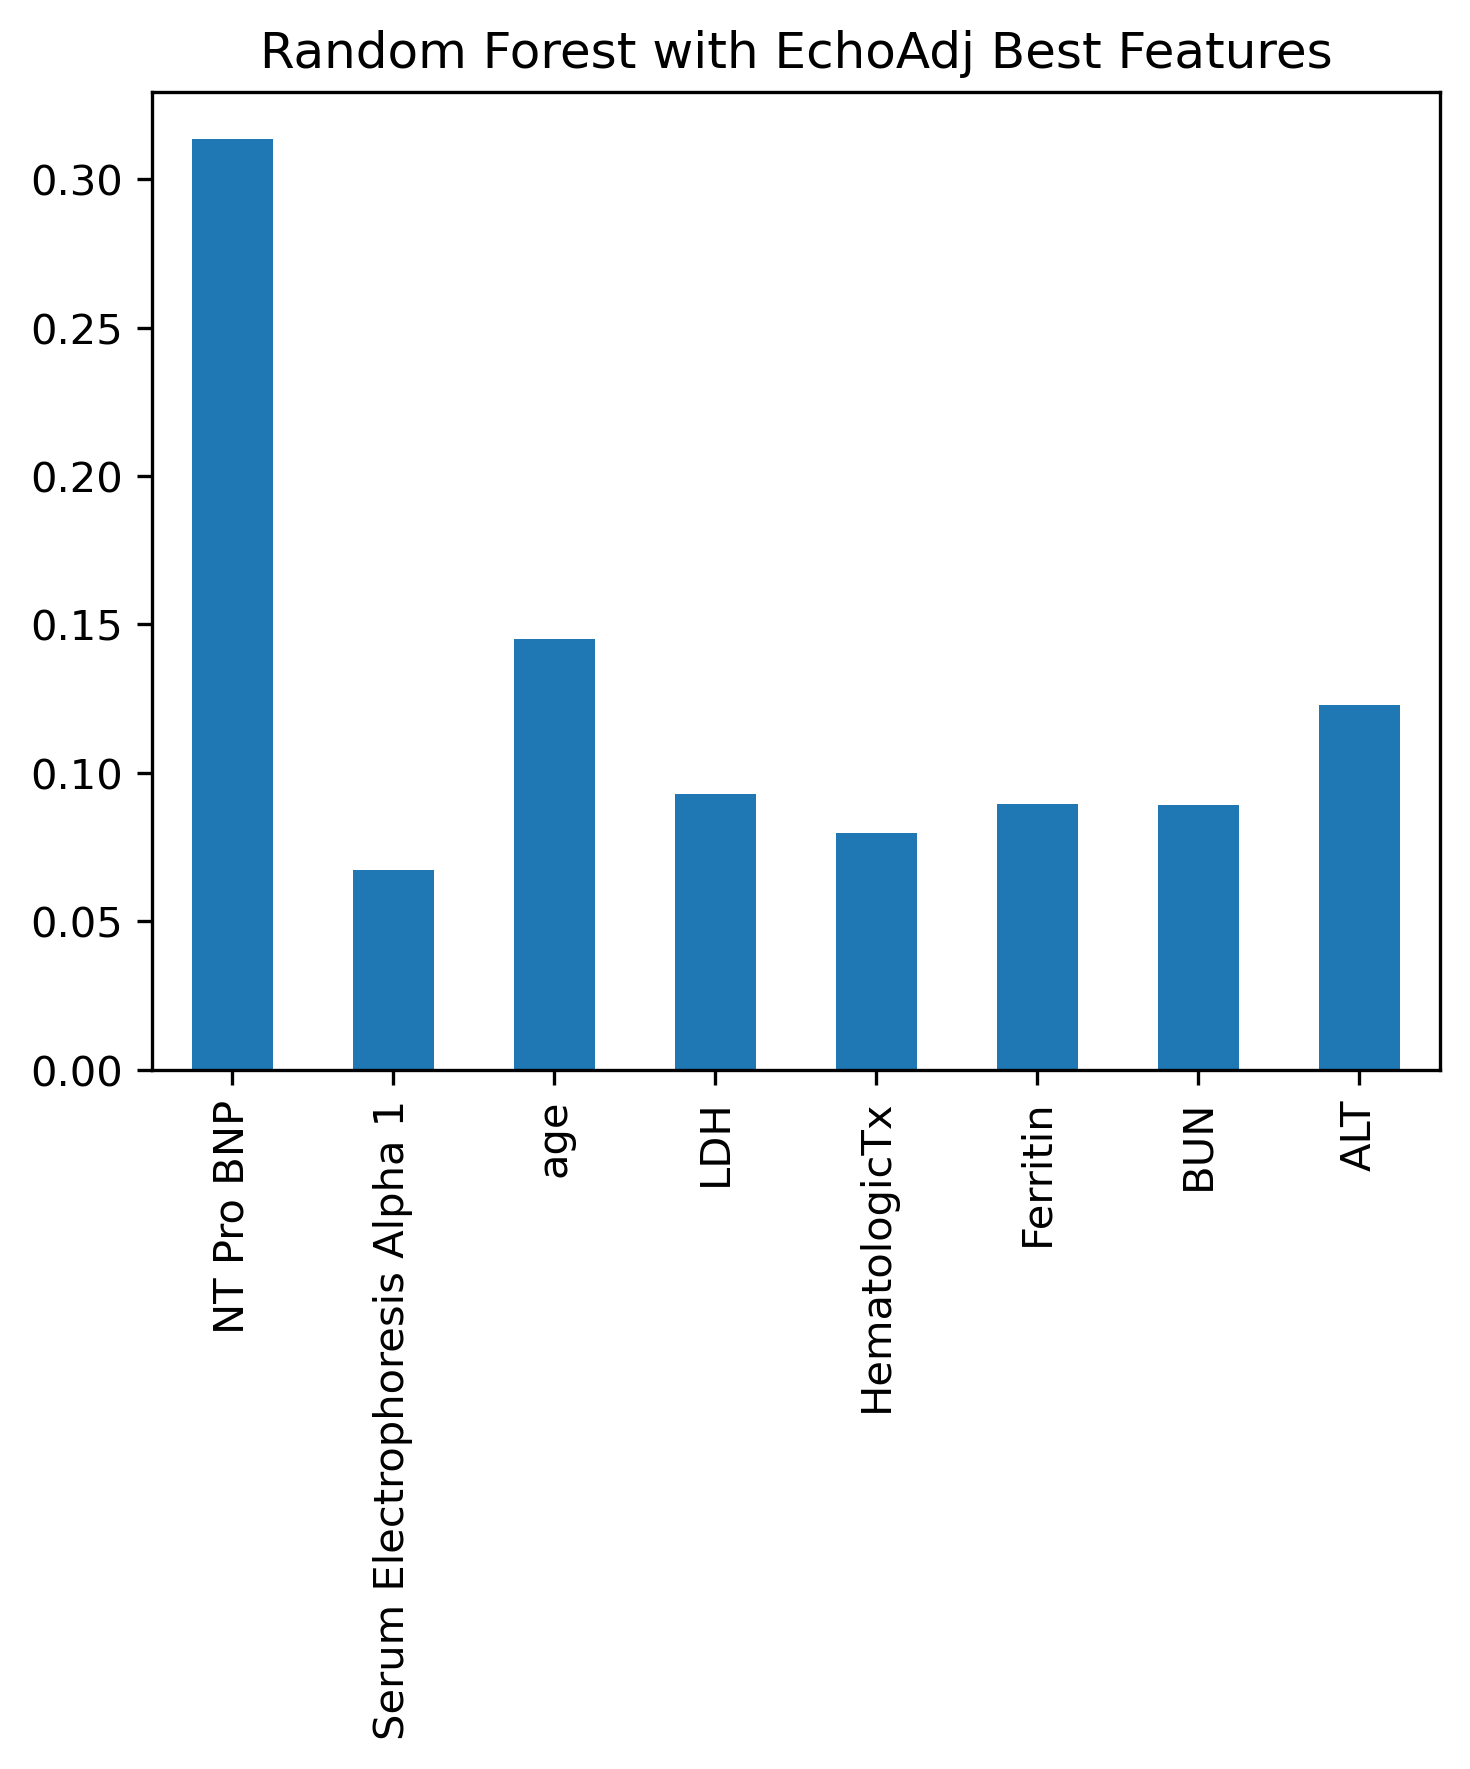

In [115]:
rnd_clf = RandomForestClassifier(random_state=0)
rnd_clf.fit(X_train_trim, y_train)
y_pred = rnd_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print("ROC: ", roc_auc_score(y_test, y_pred))

importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest with EchoAdj Best Features")
fig.tight_layout()

F1:  0.5
ROC:  0.6


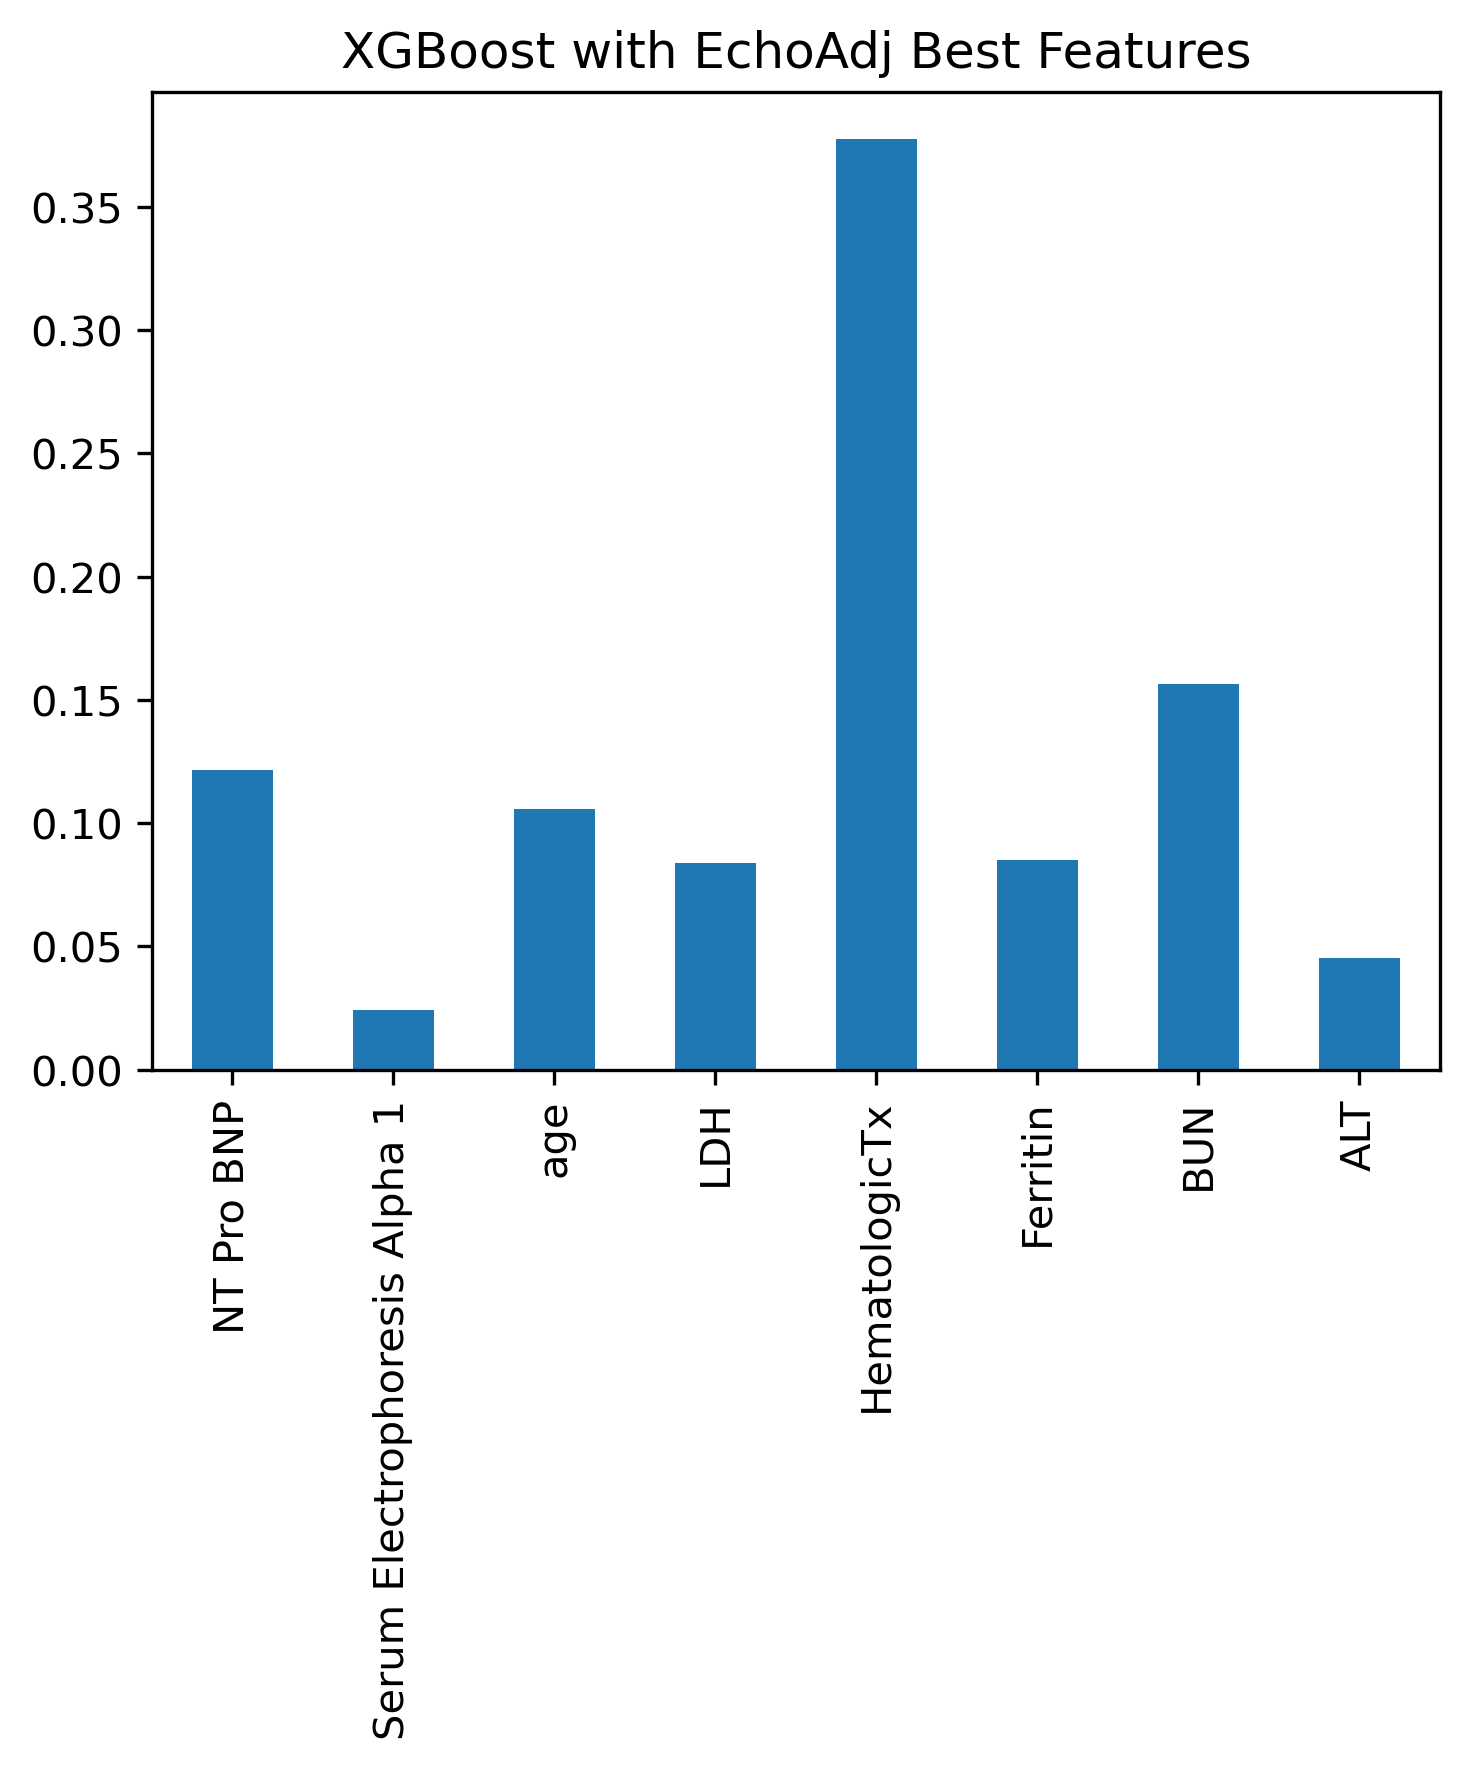

In [116]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_trim, y_train)
y_pred = xgb_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print("ROC: ", roc_auc_score(y_test, y_pred))


importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with EchoAdj Best Features")
fig.tight_layout()

In [117]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train_trim, y_train)
y_pred = lgb_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print("ROC: ", roc_auc_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 16, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] Start training from score -0.117783
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



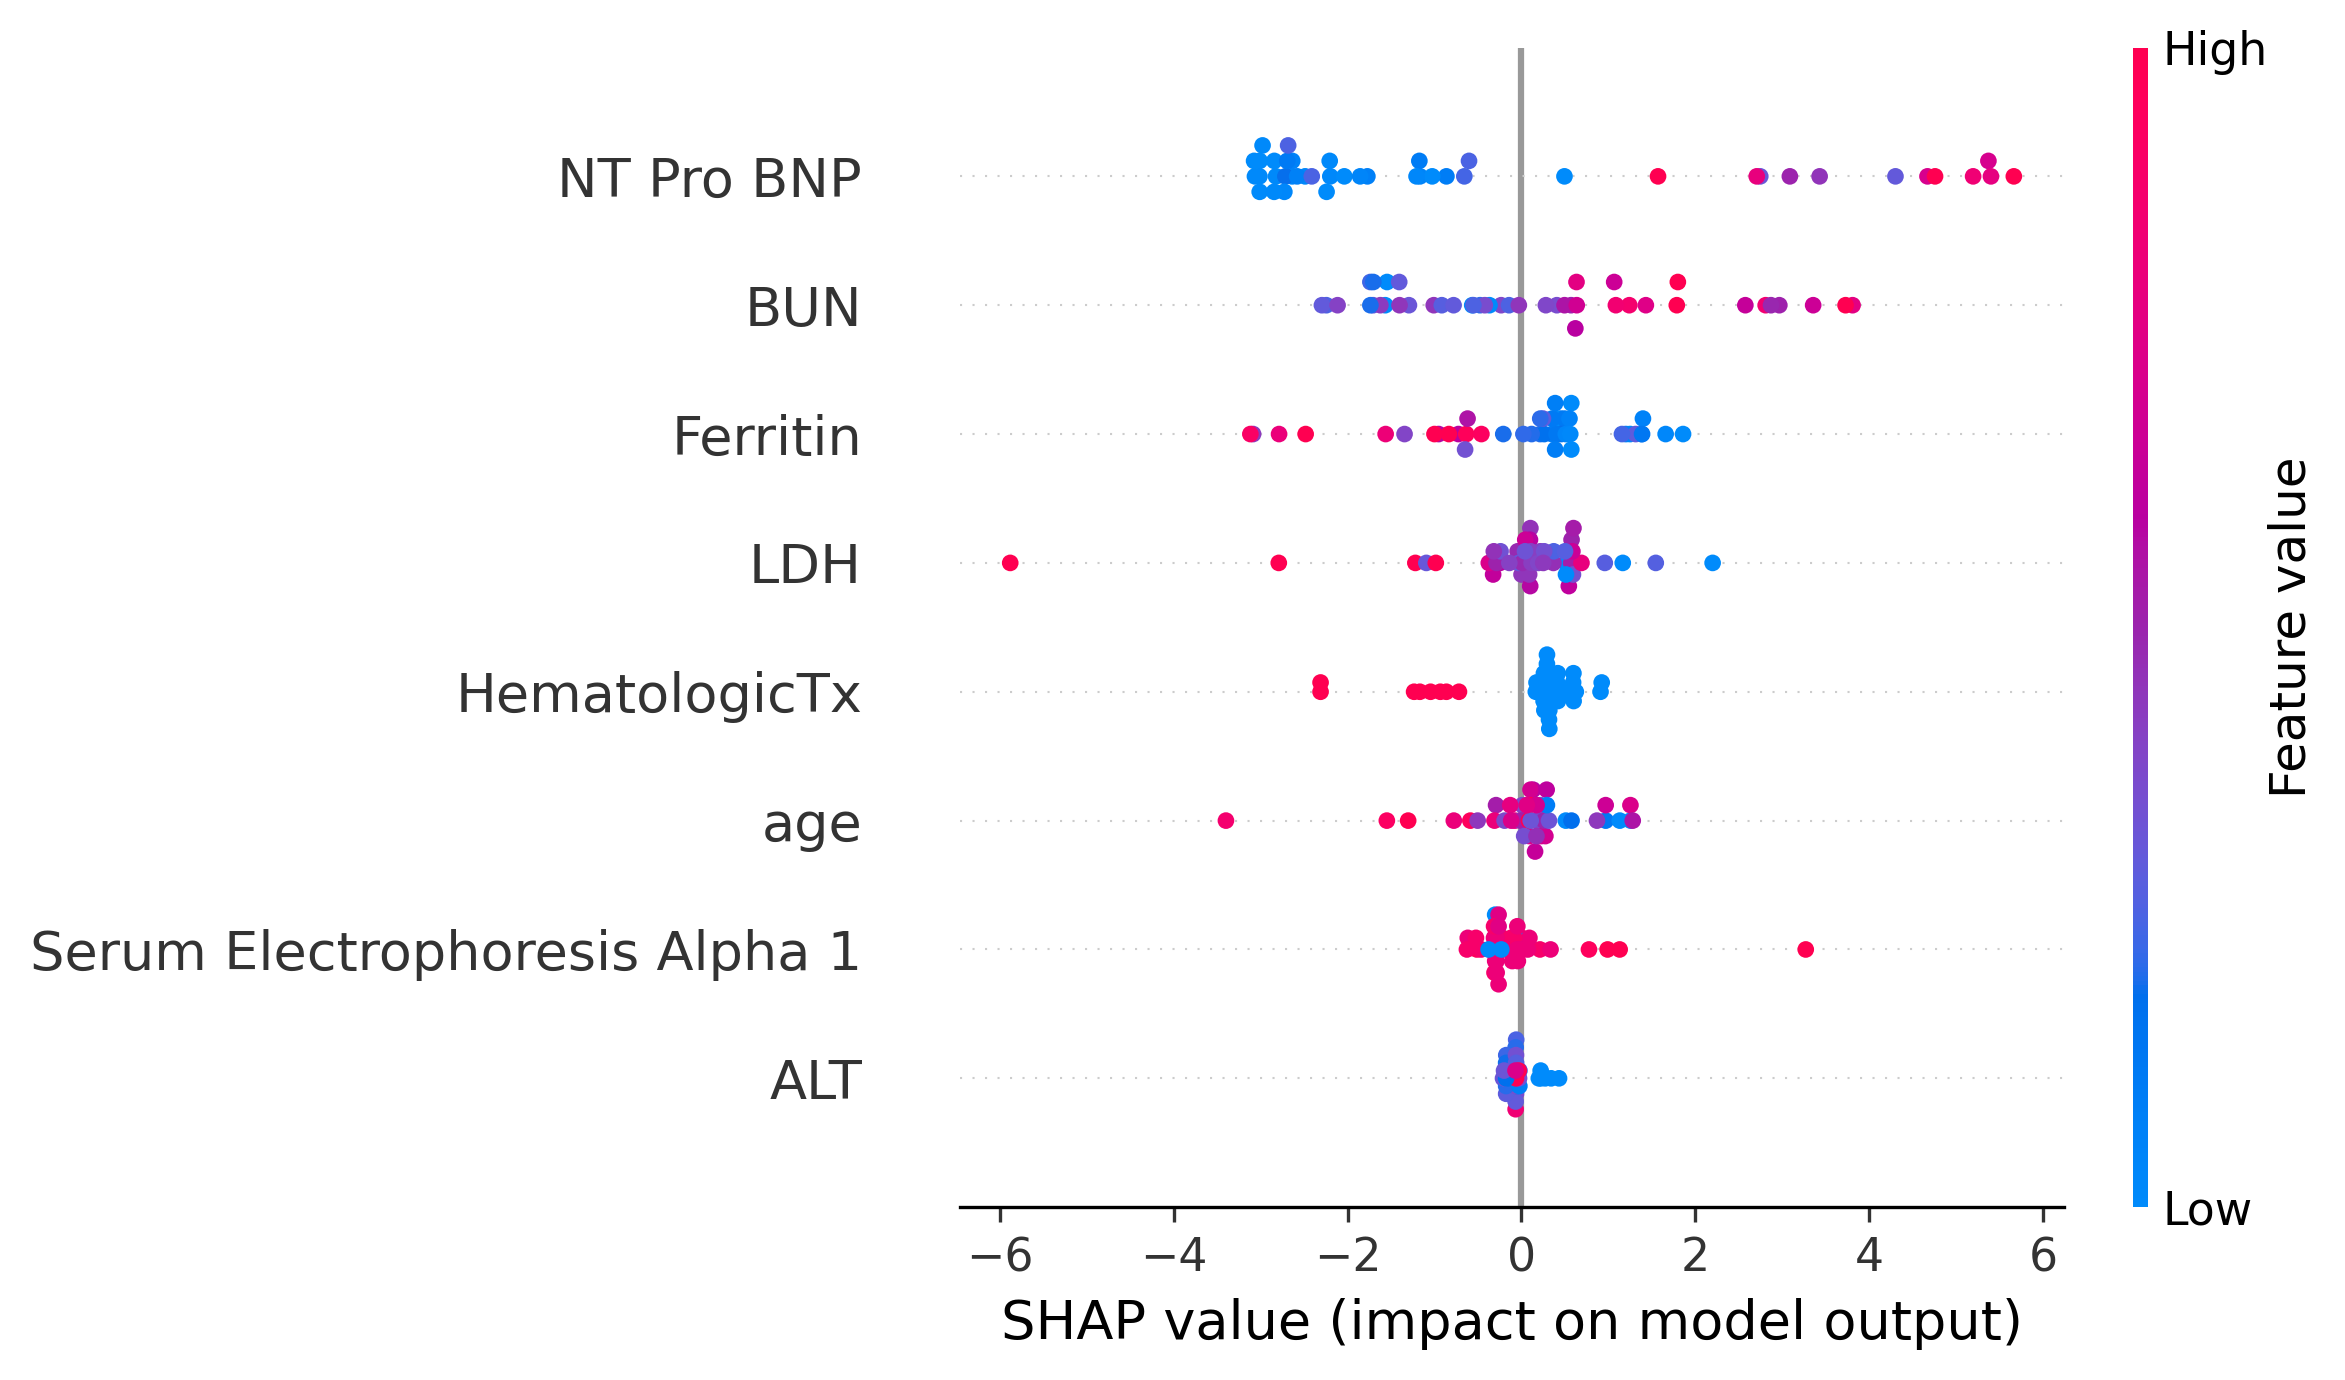

In [118]:
#borrowed from online source
#shap explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all_trim)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all_trim)

shap.summary_plot(shap_values, X_all_trim, feature_names = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)

# Show the plot
plt.show()

# exporting selected features to dataframe

In [119]:
selected_features = list(X.columns[svm_set_ranks[selected_run].features]) #getting list of selected features
dataTablePositive = dataTable[dataTable[y_column_Classification] == 1] #filtering for positive patients
dataTablePositive.index = dataTablePositive['DeID'] #setting index to patient id
dataTableNegative = dataTable[dataTable[y_column_Classification] == 0] #filtering for negative patients
dataTableNegative.index = dataTableNegative['DeID'] #setting index to patient id
df_selectedfeatures_allpts = dataTable[selected_features]
df_selectedfeatures_allpts.index = dataTable['DeID'] #adding the patient identifiers back to the dataframe


#saving this output to a sheet
outputToExcel(df_data = df_selectedfeatures_allpts[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = dataTablePositive[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "positive")
outputToExcel(df_data = dataTableNegative[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "negative")


# correlation and heat maps for the best performing features of the SVM model

In [120]:
import seaborn as sns

In [121]:
dataTable

DeID  CA_status_yes  sex_female  dx_mgus  dx_mm  age  survival(mo)  \
DeID                                                                       
B-02  B-02              1           0        1      0   48      9.466667   
C-03  C-03              1           1        0      1   59     17.000000   
E-01  E-01              1           0        1      0   50     71.300000   
E-02  E-02              1           0        1      0   64     20.466667   
F-03  F-03              1           0        0      1   61     52.000000   
G-02  G-02              1           1        0      1   36     30.000000   
I-01  I-01              1           1        0      1   55     33.000000   
I-03  I-03              1           0        1      0   67     10.033333   
J-02  J-02              1           1        0      1   68     26.000000   
K-02  K-02              1           1        0      1   68     27.000000   
M-02  M-02              1           0        1      0   70     24.800000   
N-03  N-03              1           0        0      1   69      8.000000   
O-03  O-03              1           1        0      1   71      4.233333   
Q-02  Q-02              1           0        1      0   69     41.100000   
Q-03  Q-03              1           1        0      1   41      3.466667   
T-01  T-01              1           0        0      0   71     14.433333   
V-02  V-02              1           0        0      1   79     50.000000   
W-01  W-01              1           0        0      1   57     42.000000   
X-01  X-01              1           0        1      0   80      5.300000   
X-02  X-02              1           0        1      0   63     38.233333   
Y-02  Y-02              1           1        1      0   57     12.766667   
A-02  A-02              0           1        1      0   74      7.266667   
B-03  B-03              0           0        0      1   43     18.000000   
C-01  C-01              0           1        0      0   56     27.000000   
C-02  C-02              0           0        0      1   59     33.000000   
E-03  E-03              0           0        1      0   62     13.866667   
F-01  F-01              0           0        0      1   55    147.000000   
G-03  G-03              0           1        1      0   69     11.533333   
H-01  H-01              0           0        1      0   56     47.066667   
H-02  H-02              0           0        0      1   65     26.000000   
M-01  M-01              0           0        0      1   47     83.000000   
N-01  N-01              0           0        0      0   79     15.000000   
N-02  N-02              0           0        0      1   76     10.000000   
P-01  P-01              0           0        0      1   77     53.000000   
P-02  P-02              0           1        0      1   64     26.000000   
Q-01  Q-01              0           1        1      0   57     48.800000   
R-01  R-01              0           0        0      1   68     21.000000   
R-03  R-03              0           1        1      0   62     12.966667   
S-02  S-02              0           1        0      1   69     20.000000   
T-02  T-02              0           0        0      1   60     19.000000   
V-01  V-01              0           1        0      1   66     43.000000   
W-02  W-02              0           0        1      0   72     13.500000   
Y-01  Y-01              0           0        0      1   59     40.000000   
Z-01  Z-01              0           1        0      0   72      2.000000   

      ChemoTx  HematologicTx  RadiationTx  ...  Serum Electrophoresis Alpha 1  \
DeID                                       ...                                  
B-02        0              0            0  ...                            0.4   
C-03        2              0            0  ...                            0.5   
E-01        0              0            0  ...                           -1.0   
E-02        0              0            0  ...                            0.3   
F-03        4          

In [122]:
# create correlation matrix for all the input features
feature_correlation = dataTable.drop(columns= 'DeID').corr(method='spearman')
selected_features = list(X.columns[svm_set_ranks[selected_run].features])

#for CA positive
feature_correlation_CApositive = dataTable[dataTable[y_column_Classification] == 1].drop(columns = "DeID").corr(method='spearman')

#for CA negative
feature_correlation_CAnegative = dataTable[dataTable[y_column_Classification] == 0].drop(columns = "DeID").corr(method='spearman')

In [123]:
outputToExcel(df_data = feature_correlation, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = feature_correlation_CApositive, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCApos")
outputToExcel(df_data = feature_correlation_CAnegative, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCAneg")

In [124]:
colormap = "RdBu"

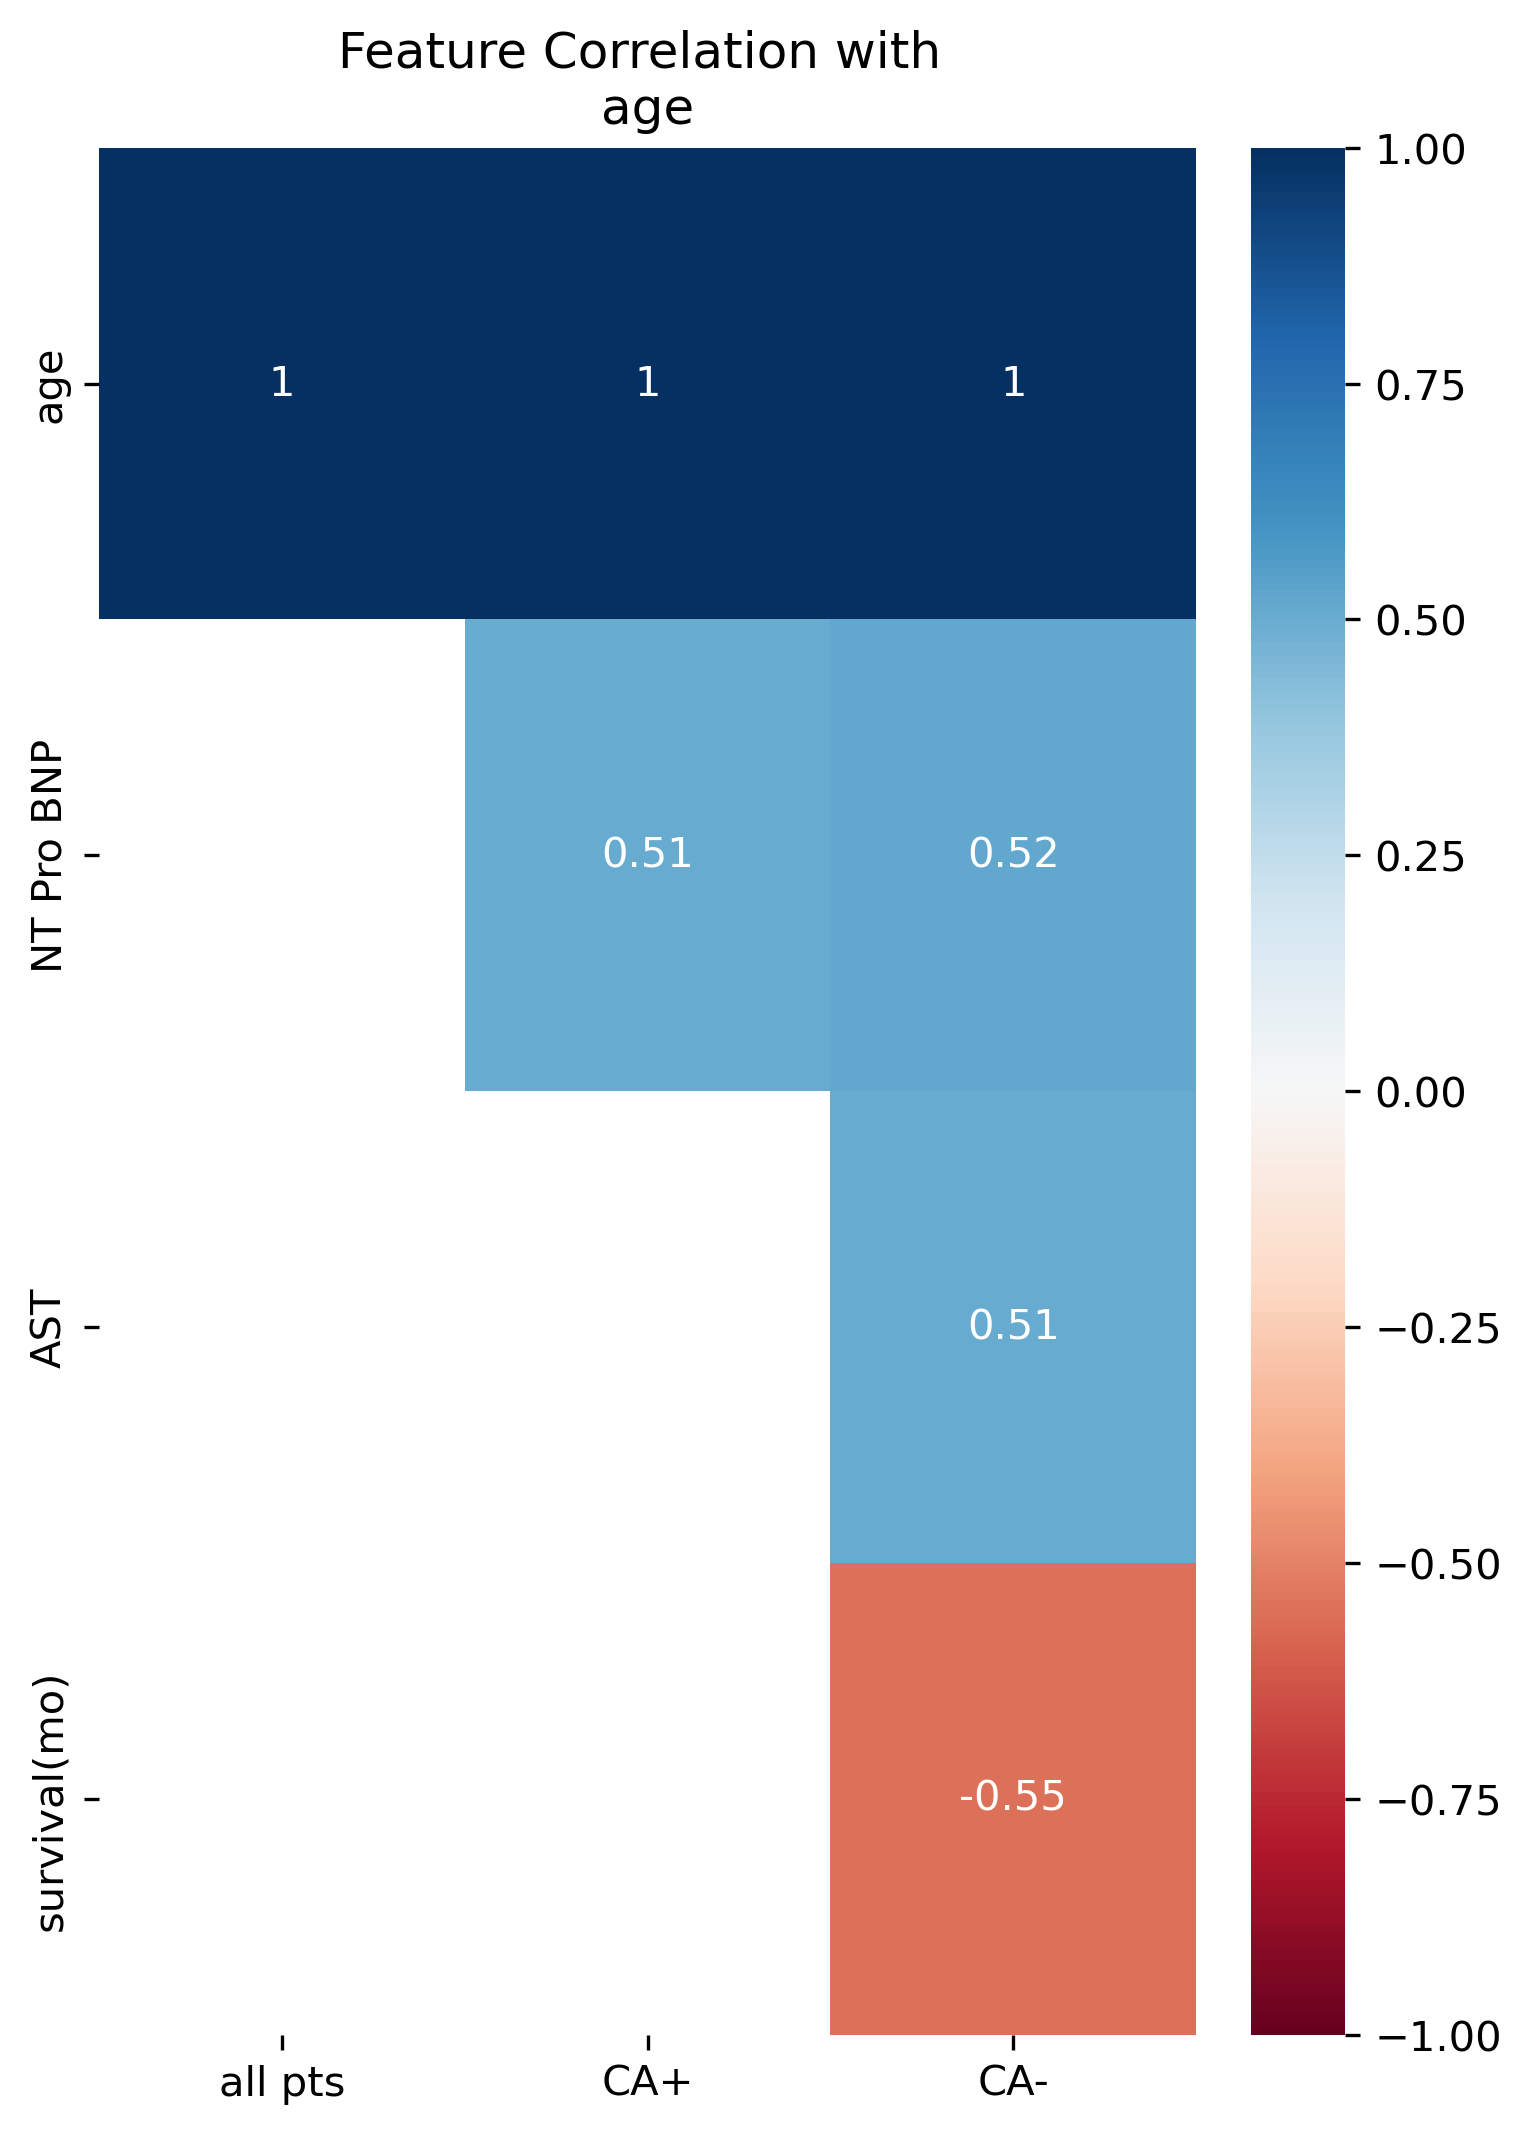

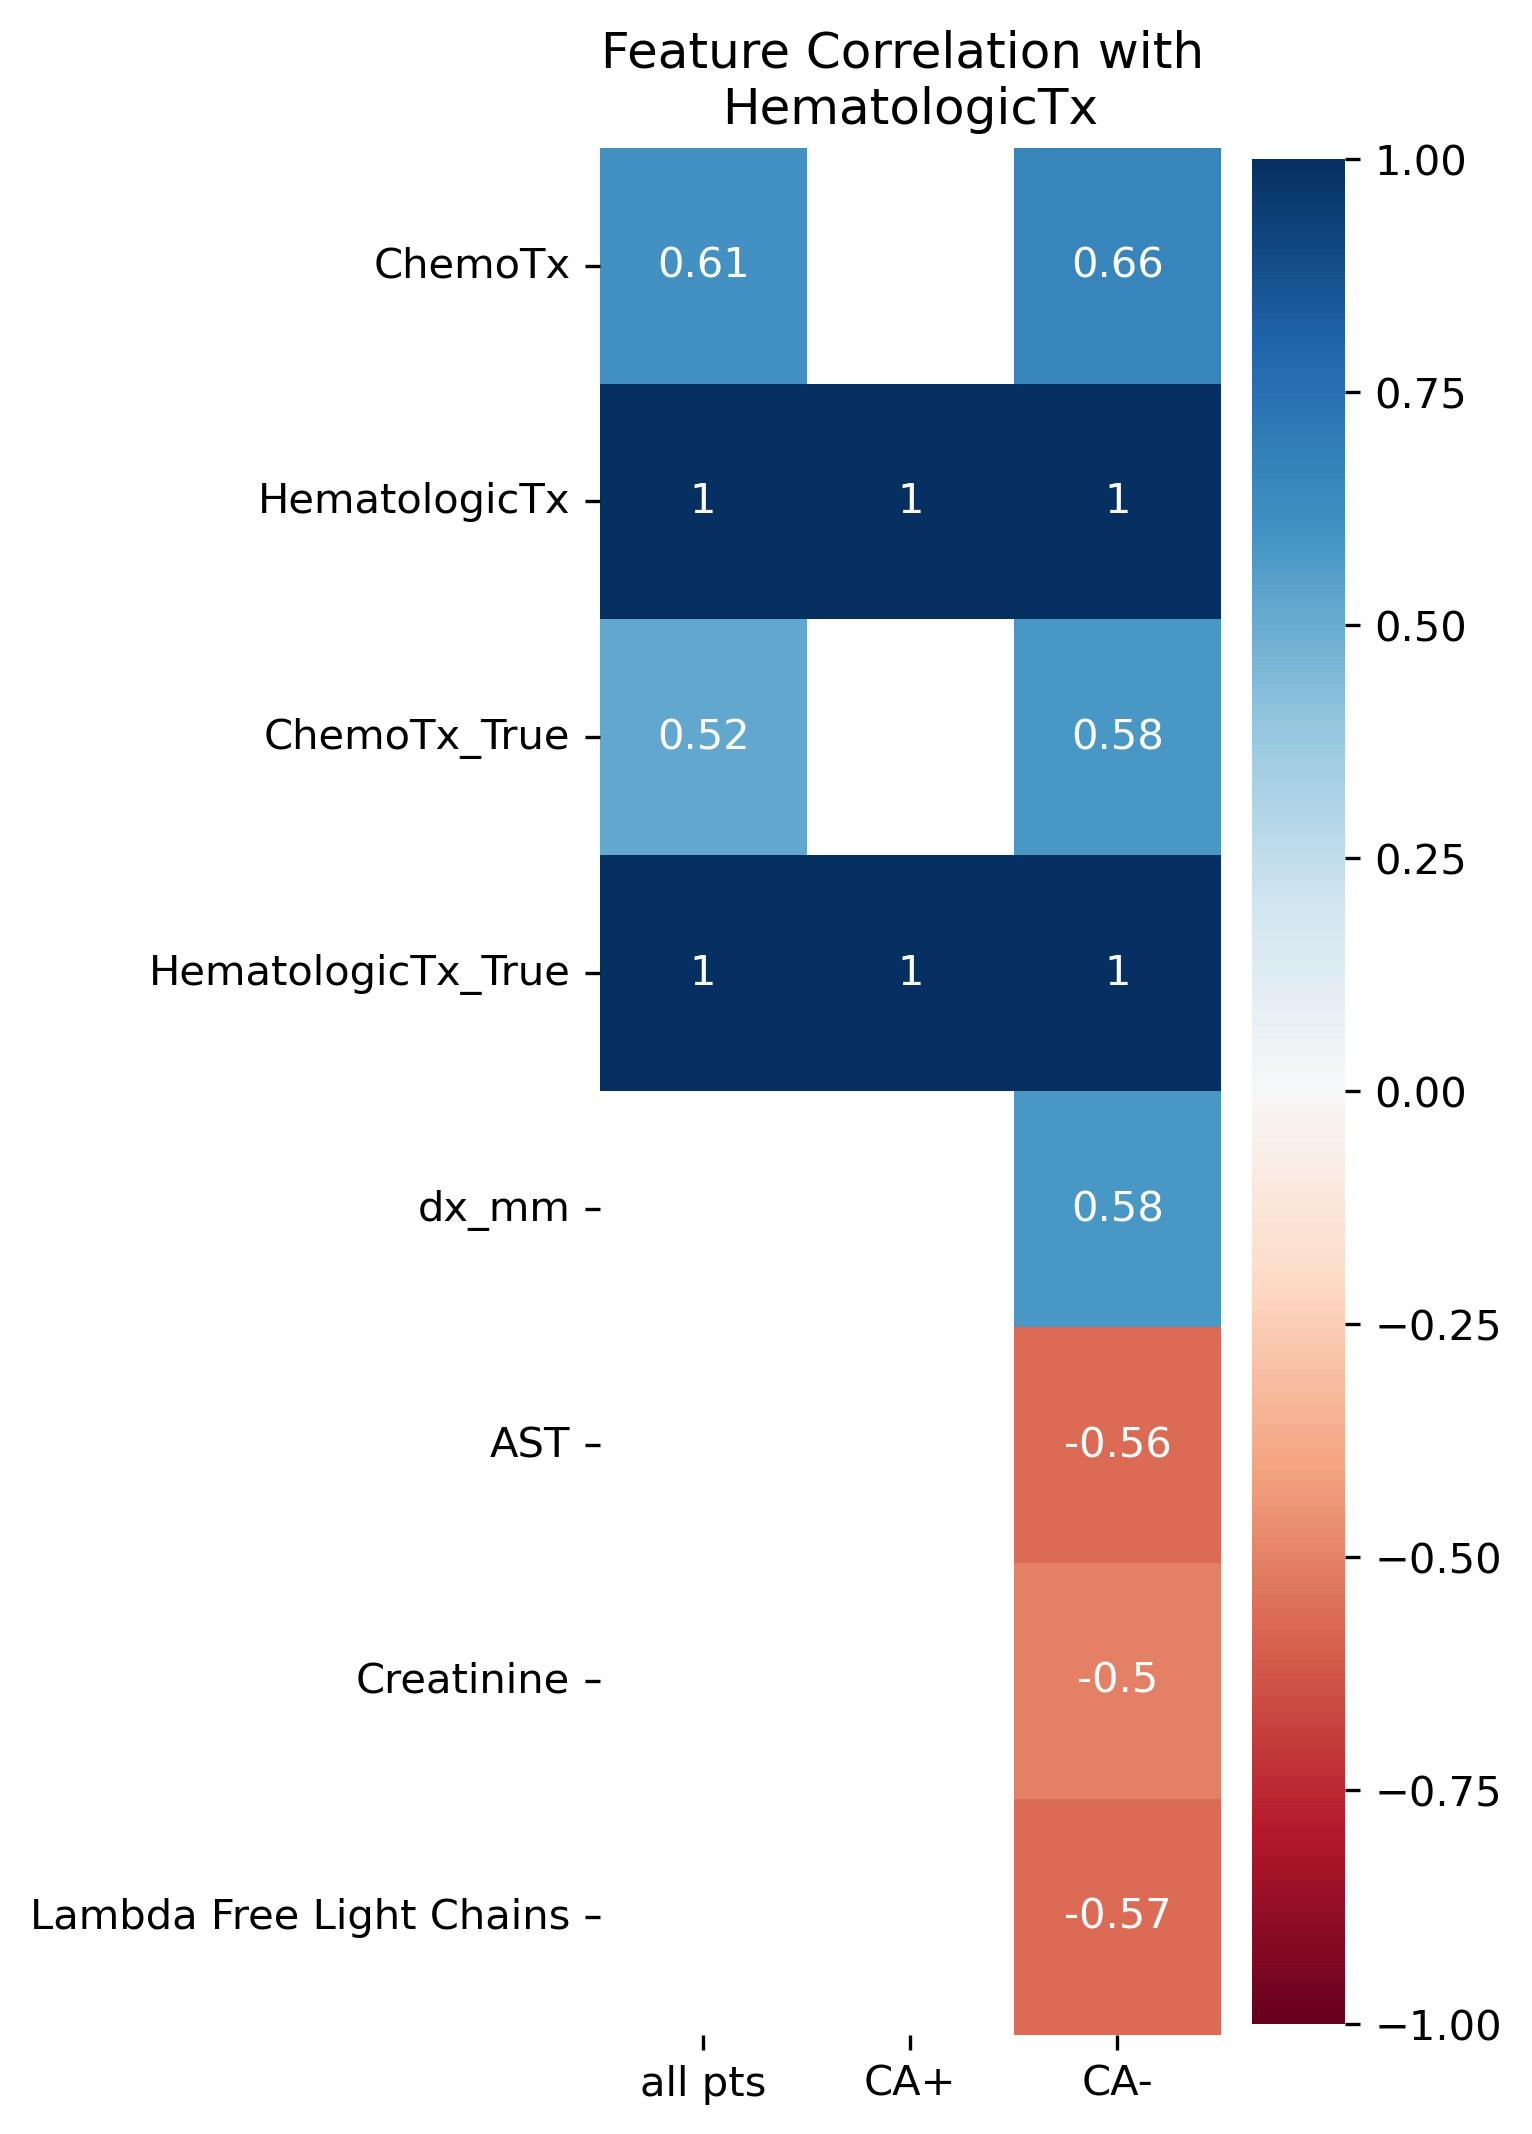

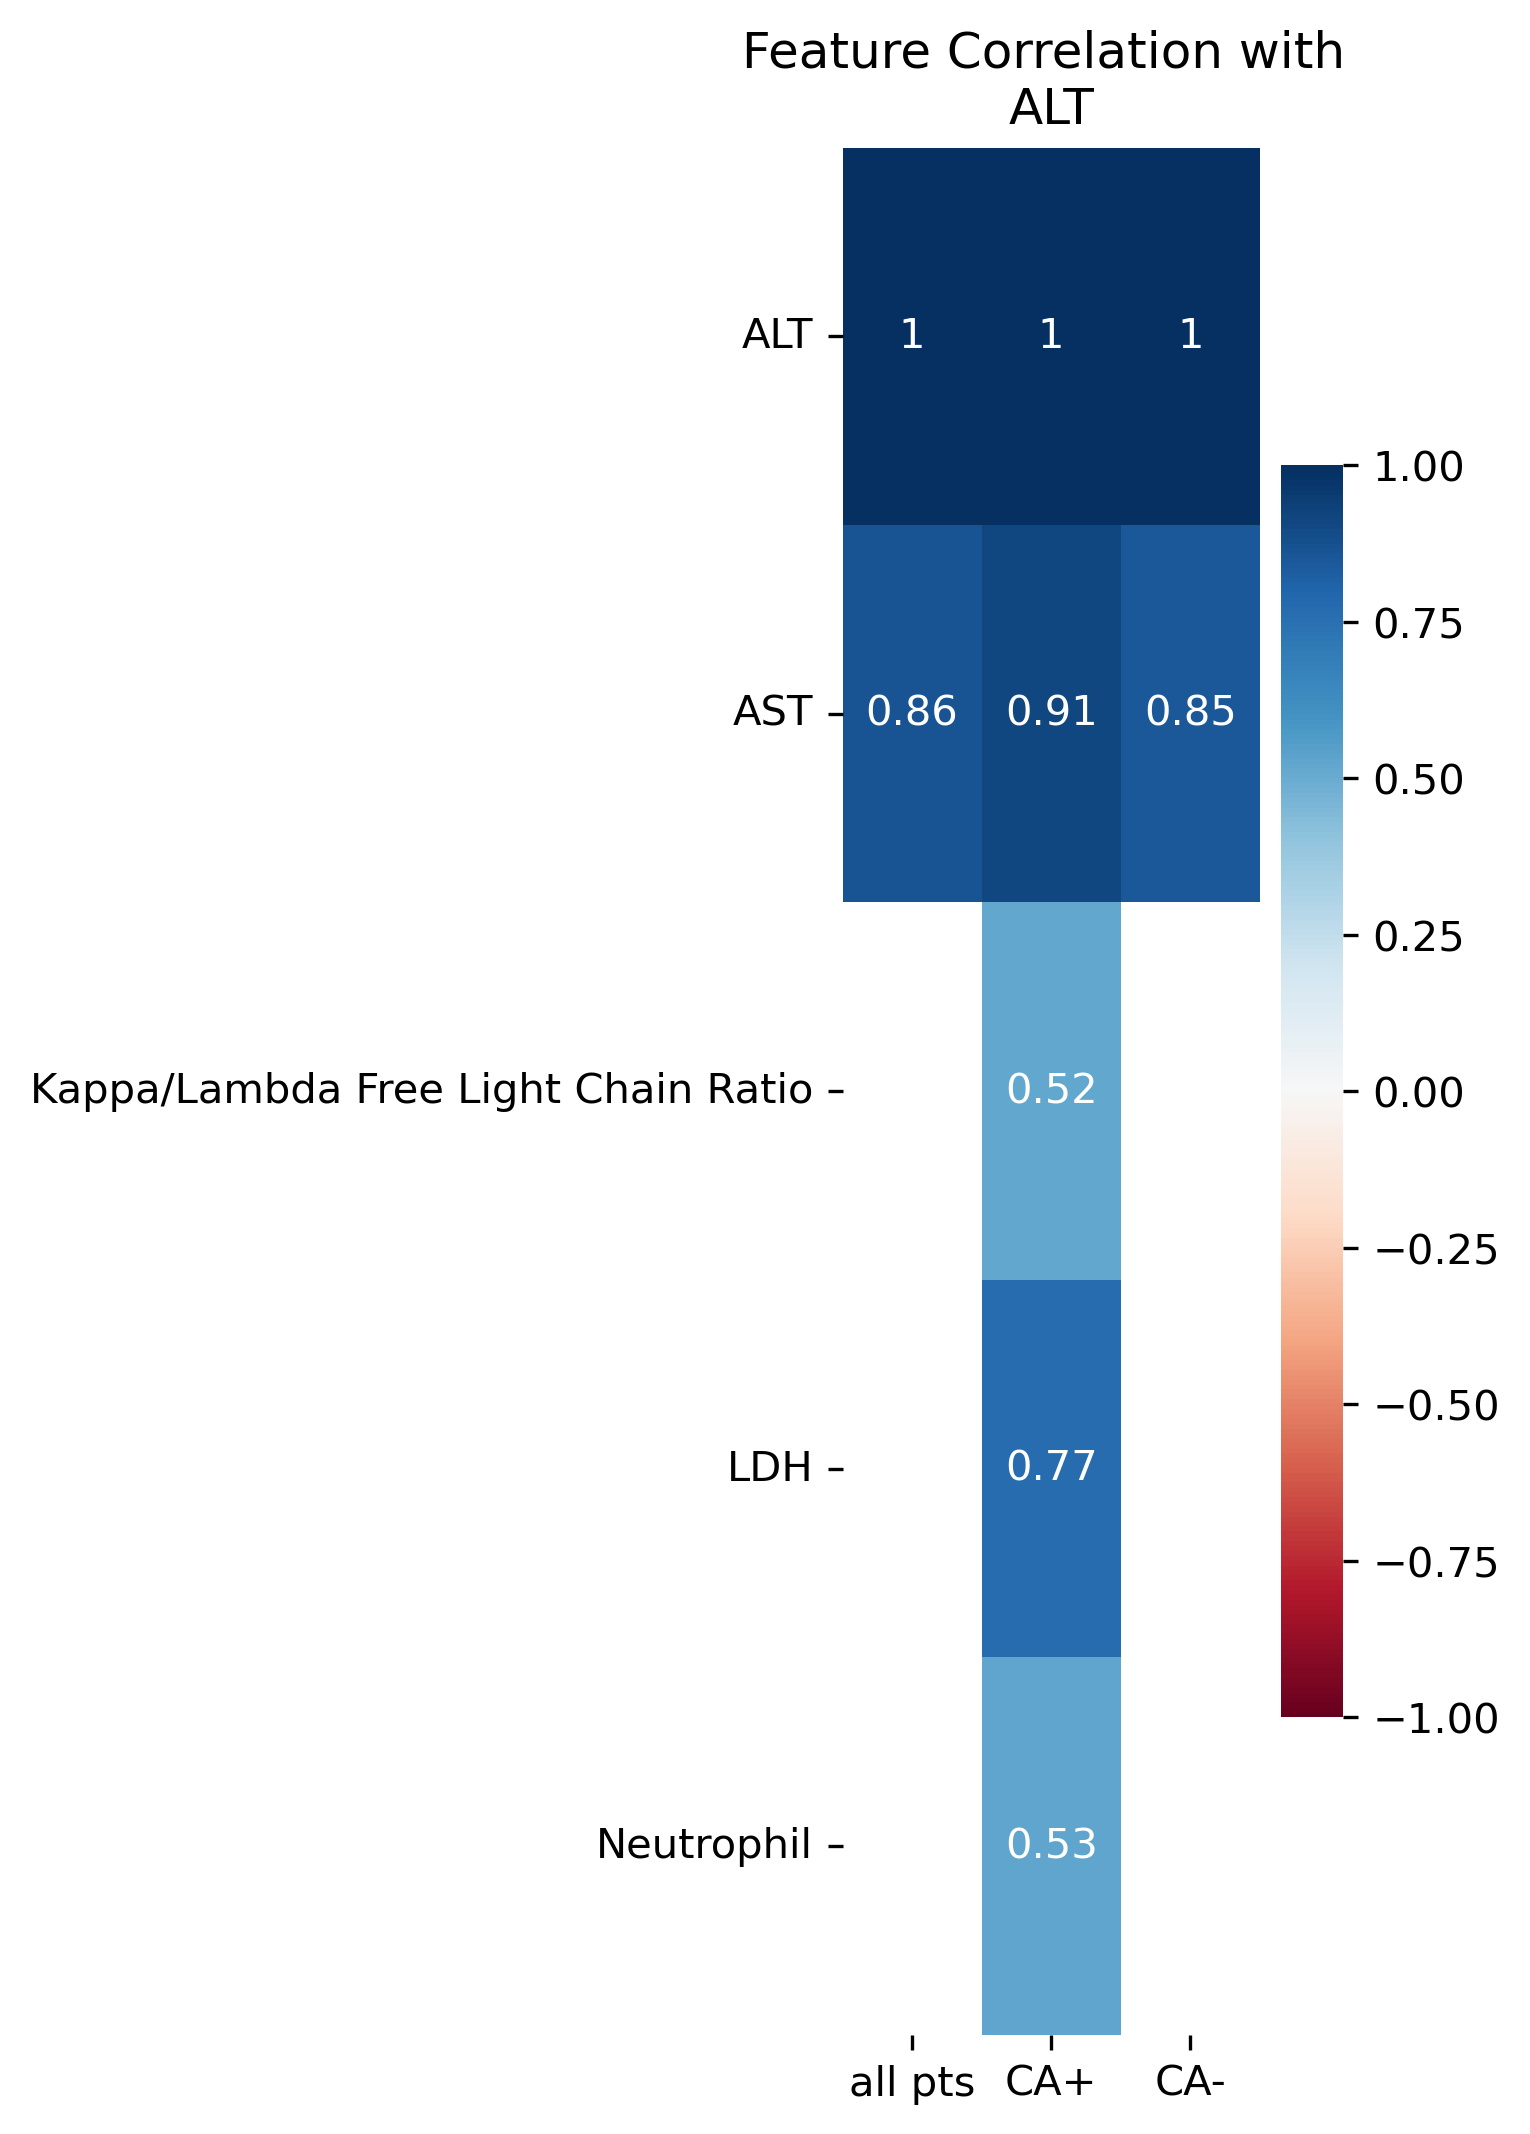

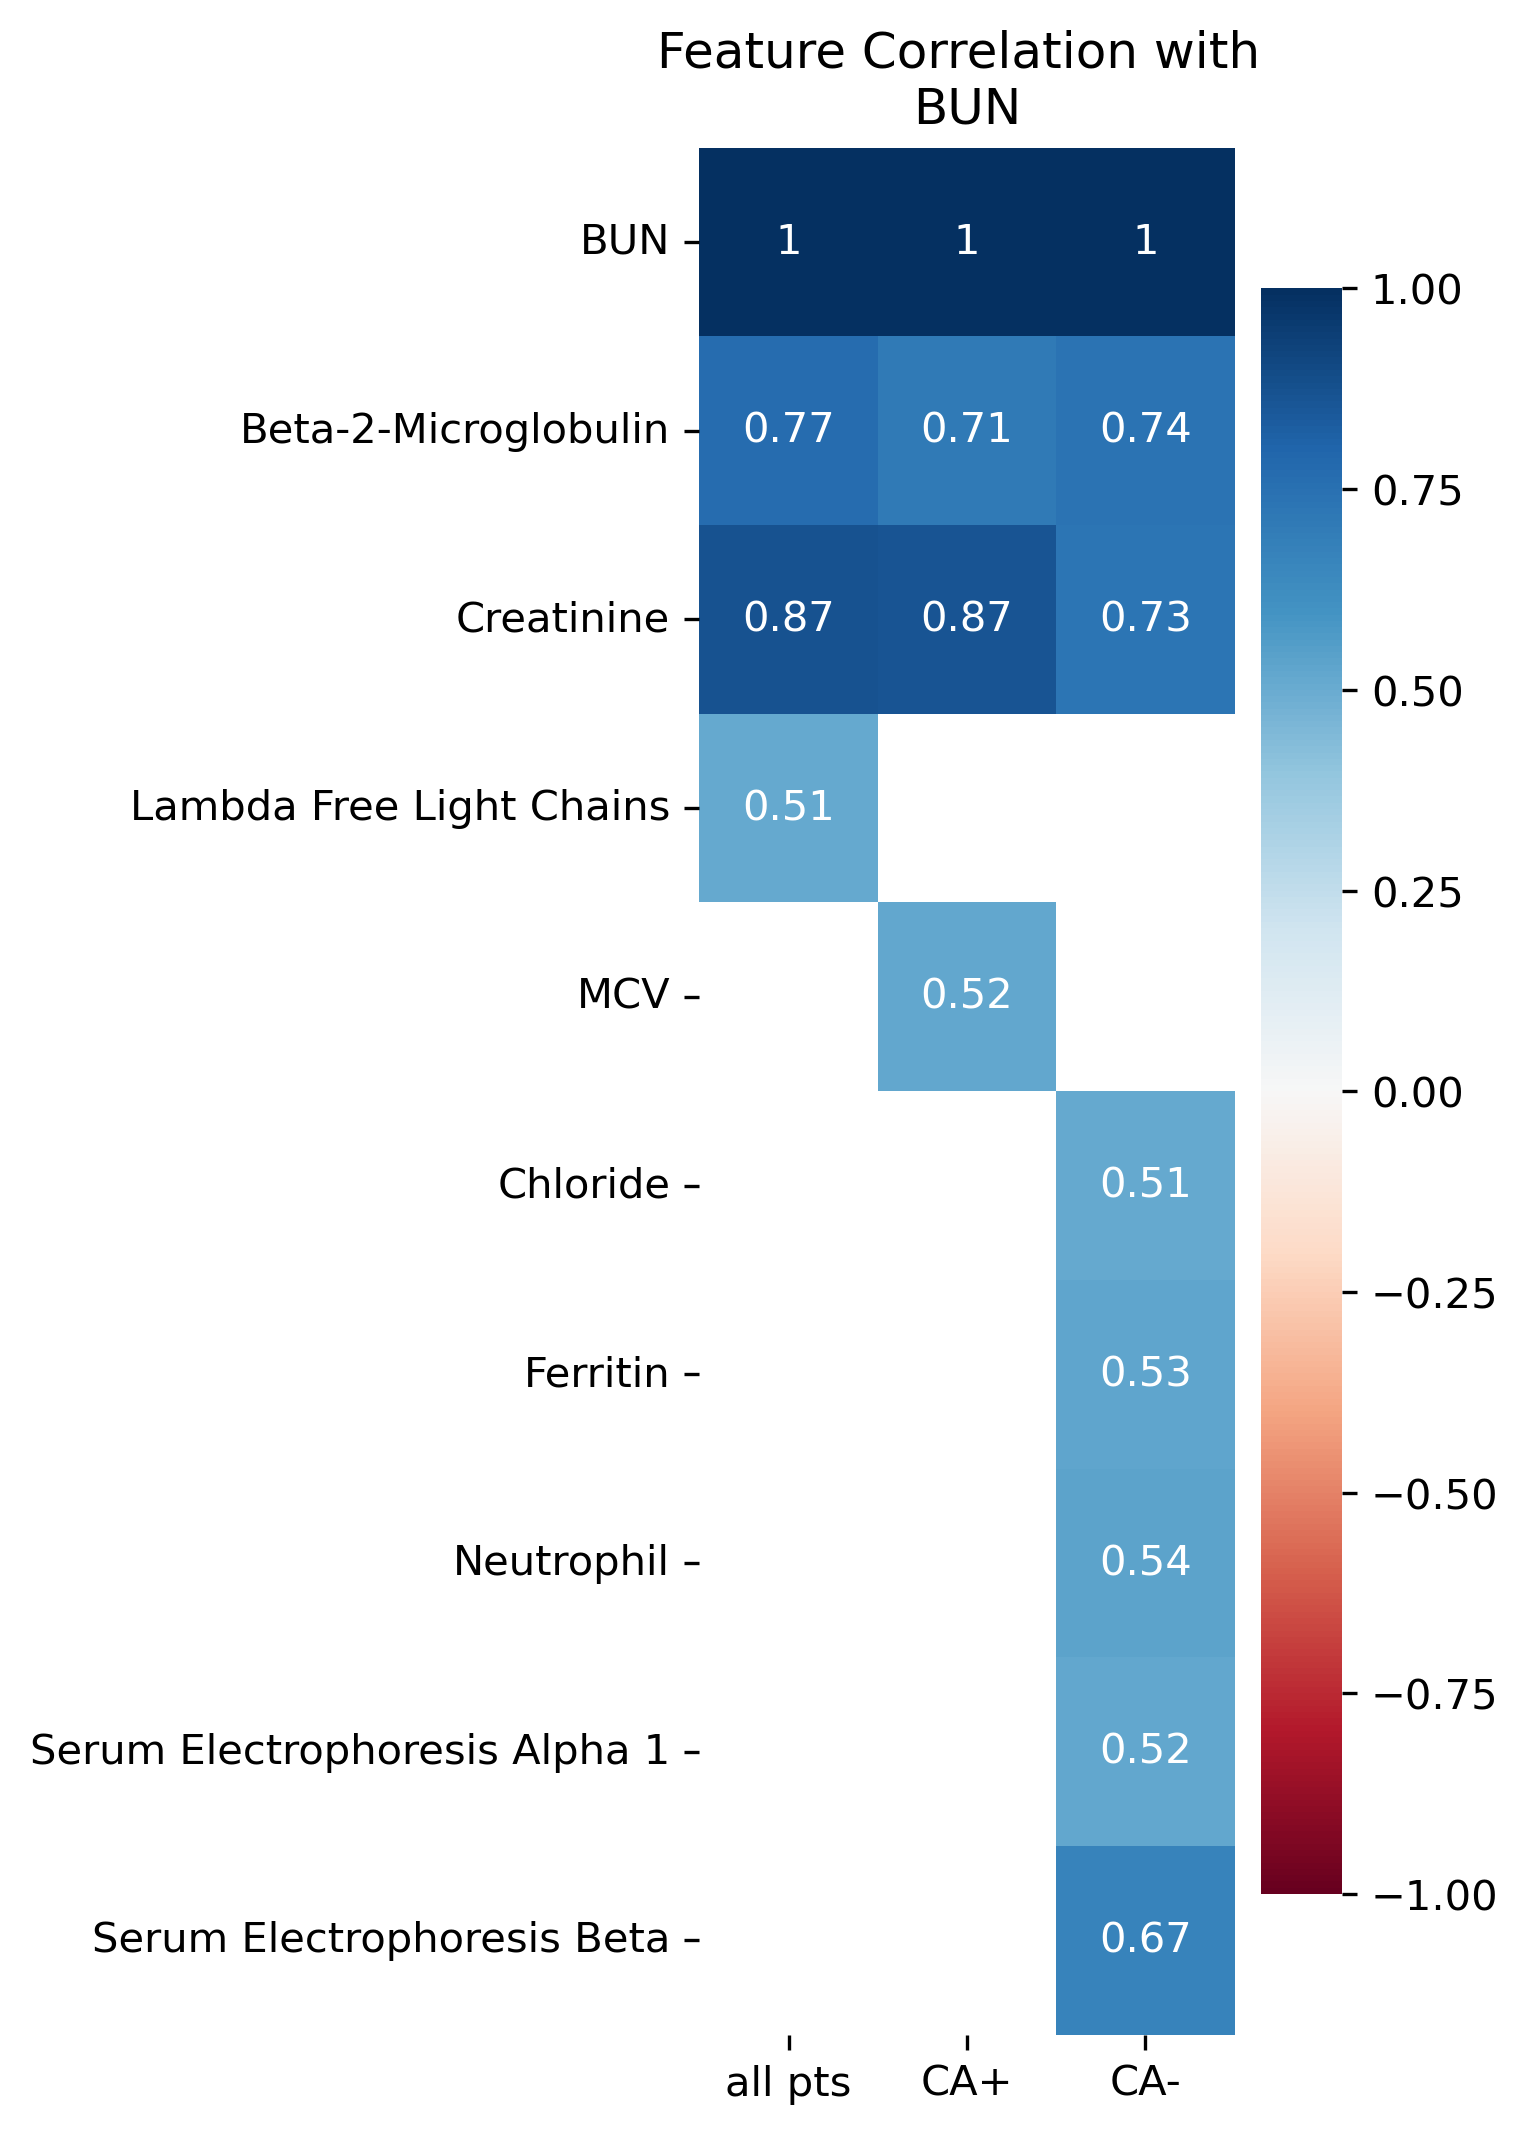

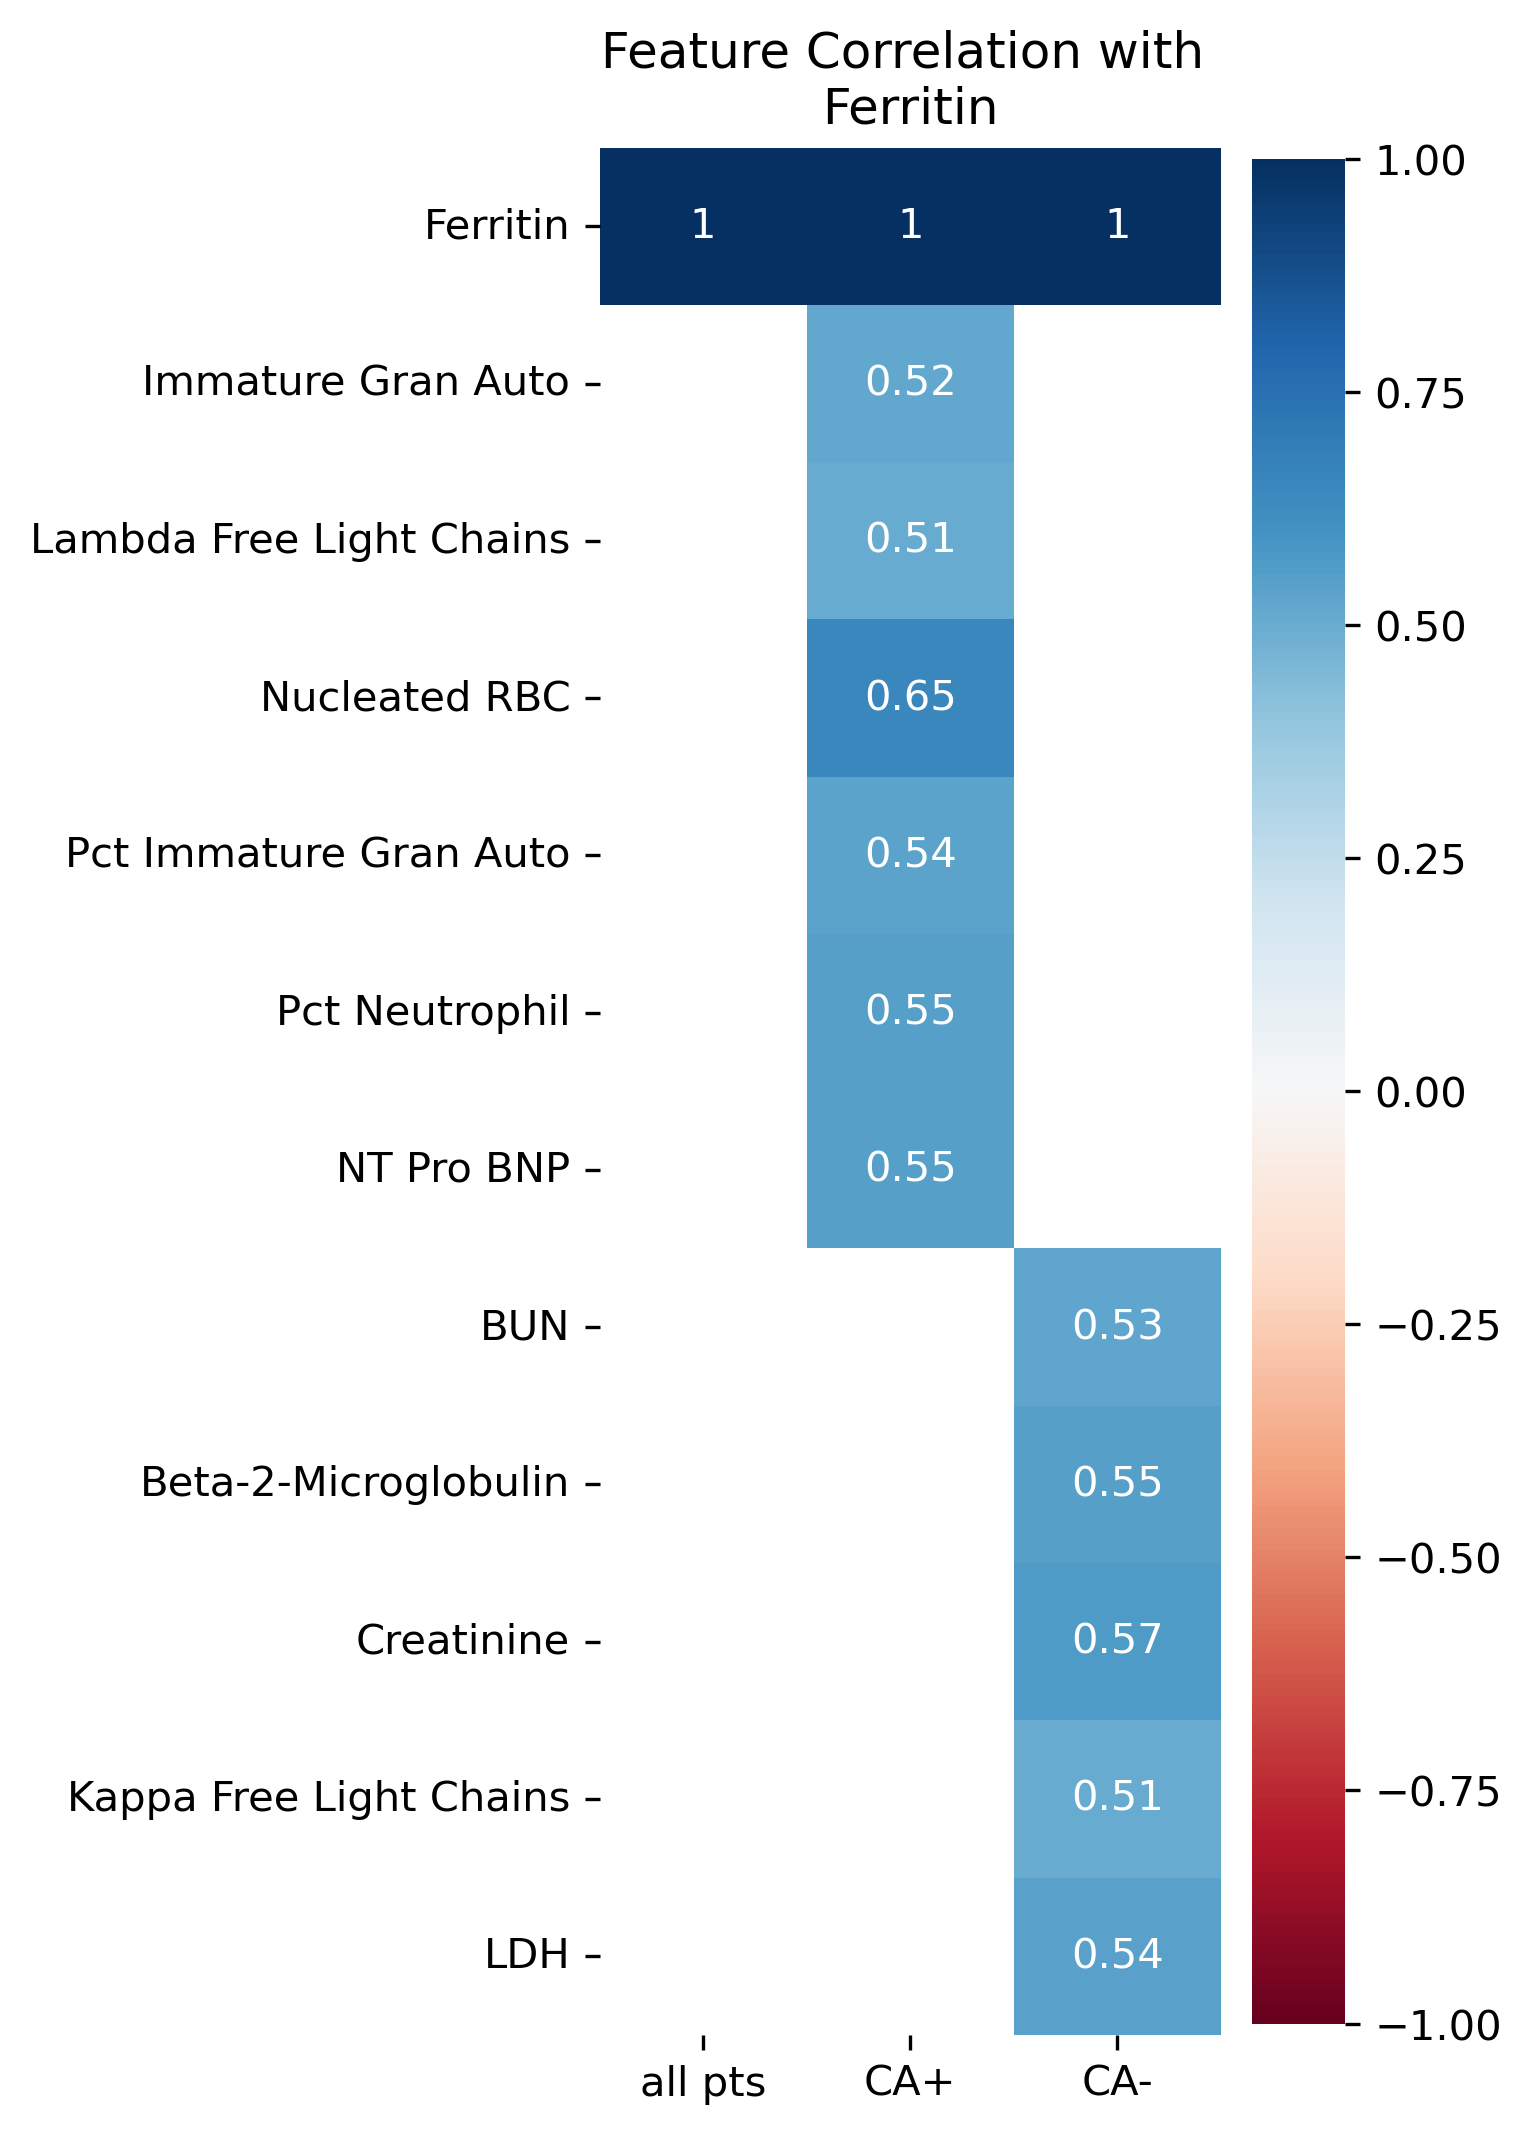

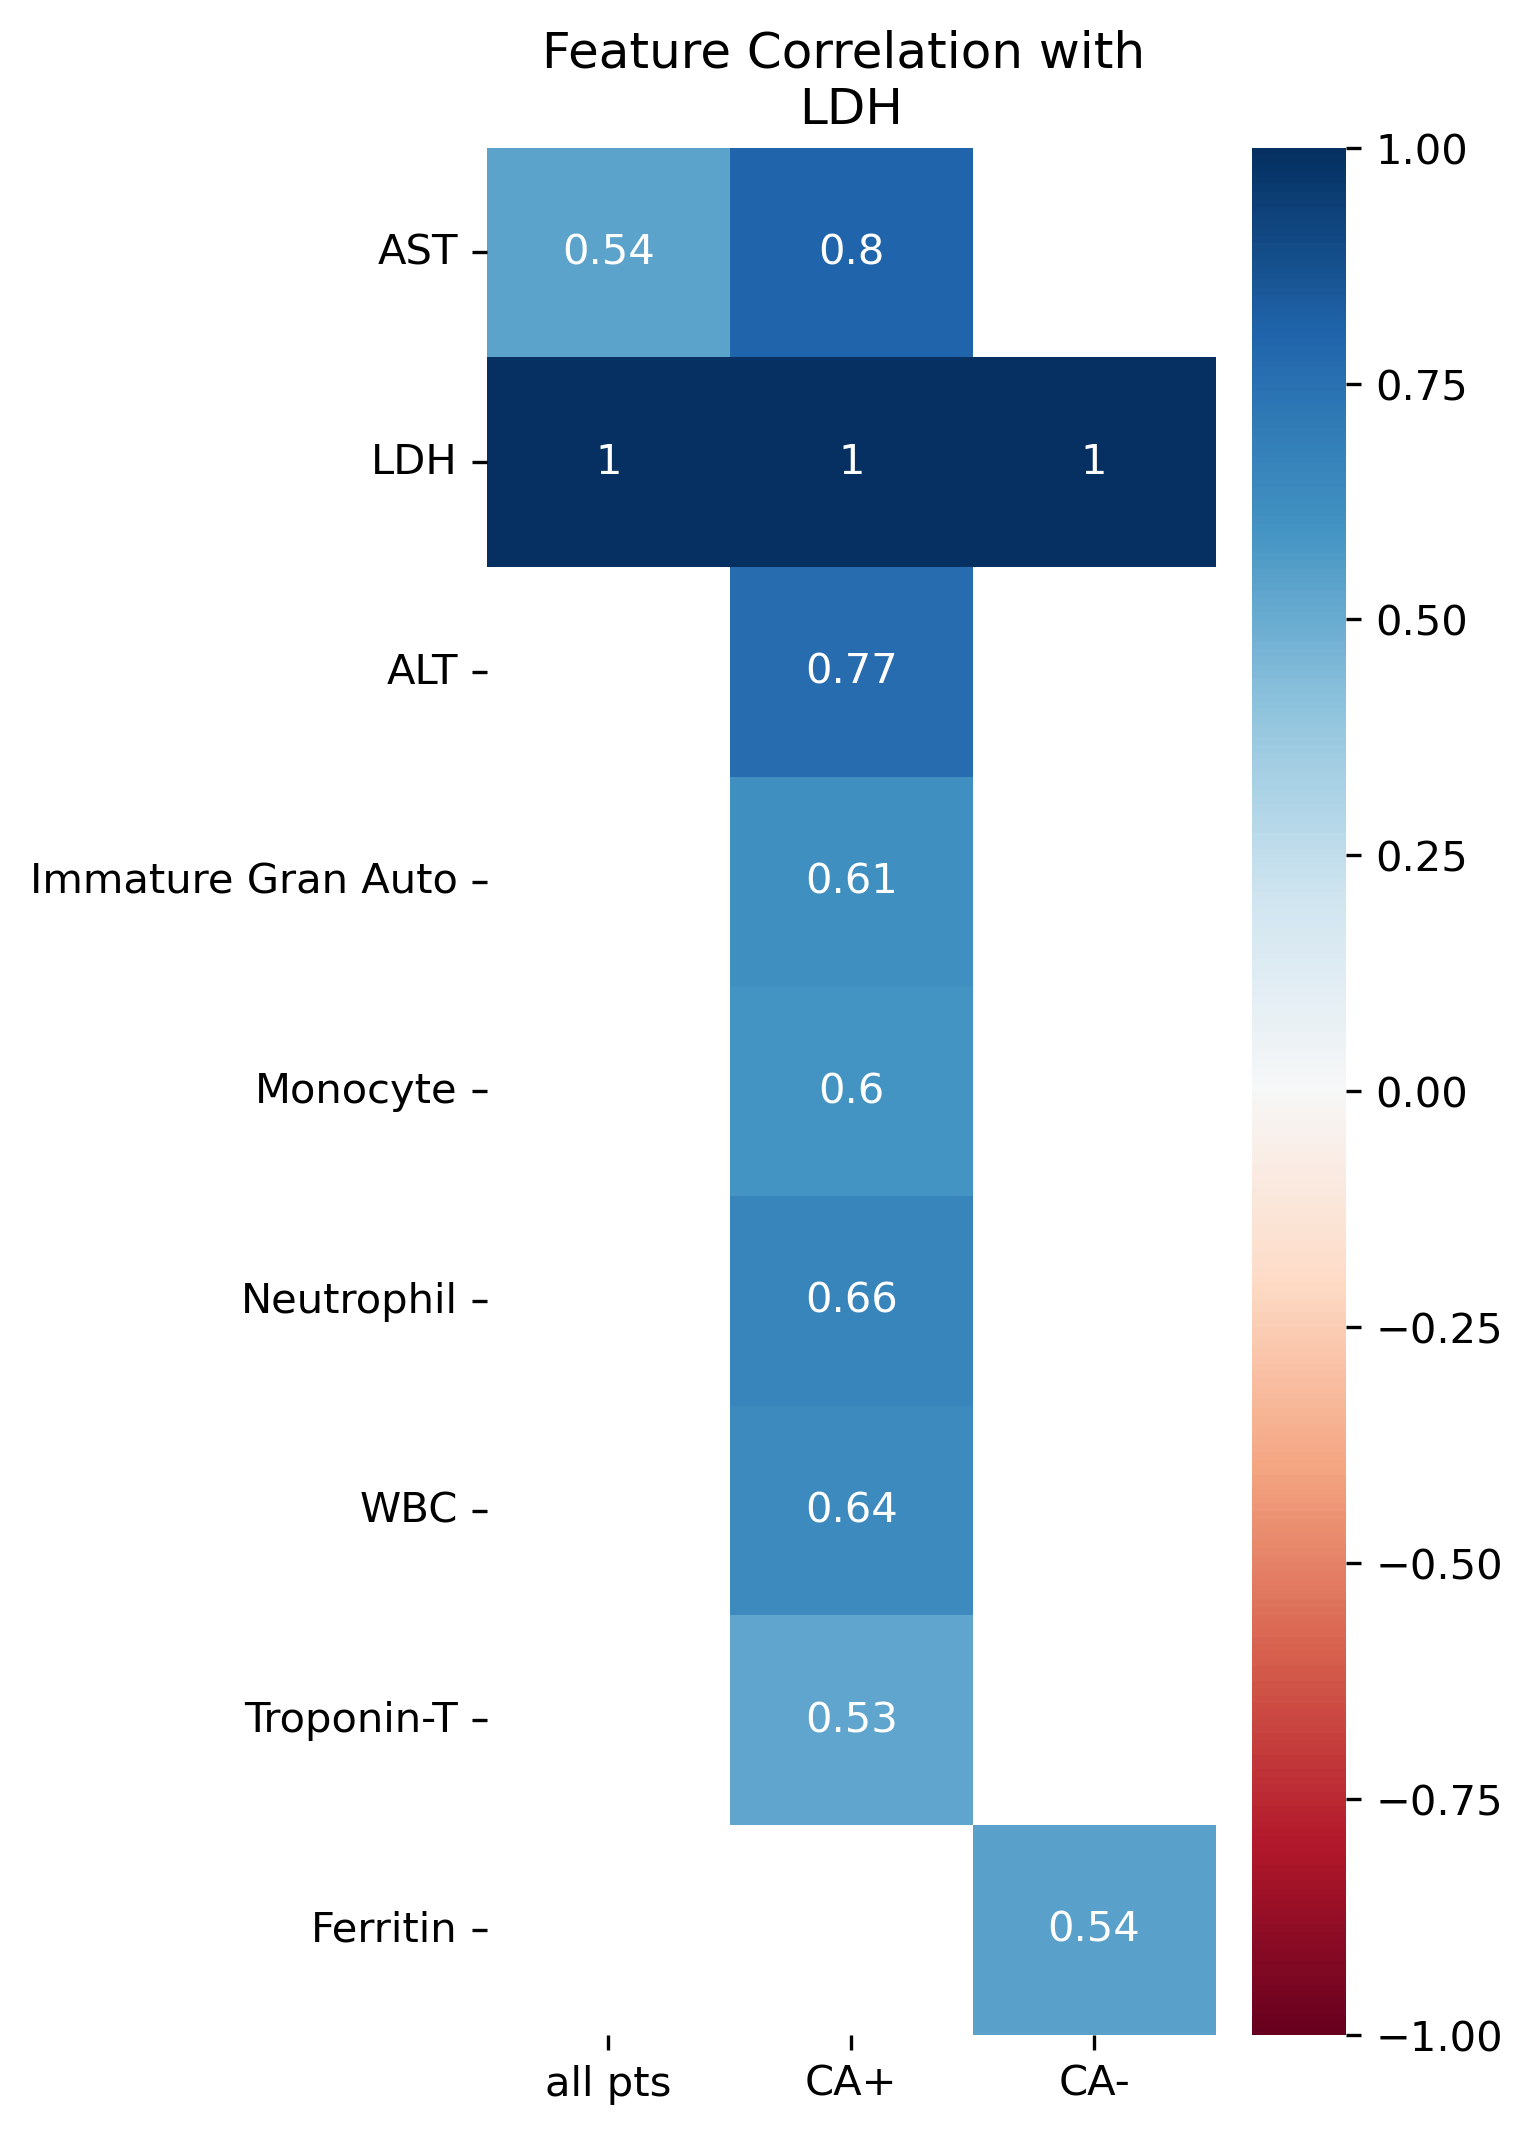

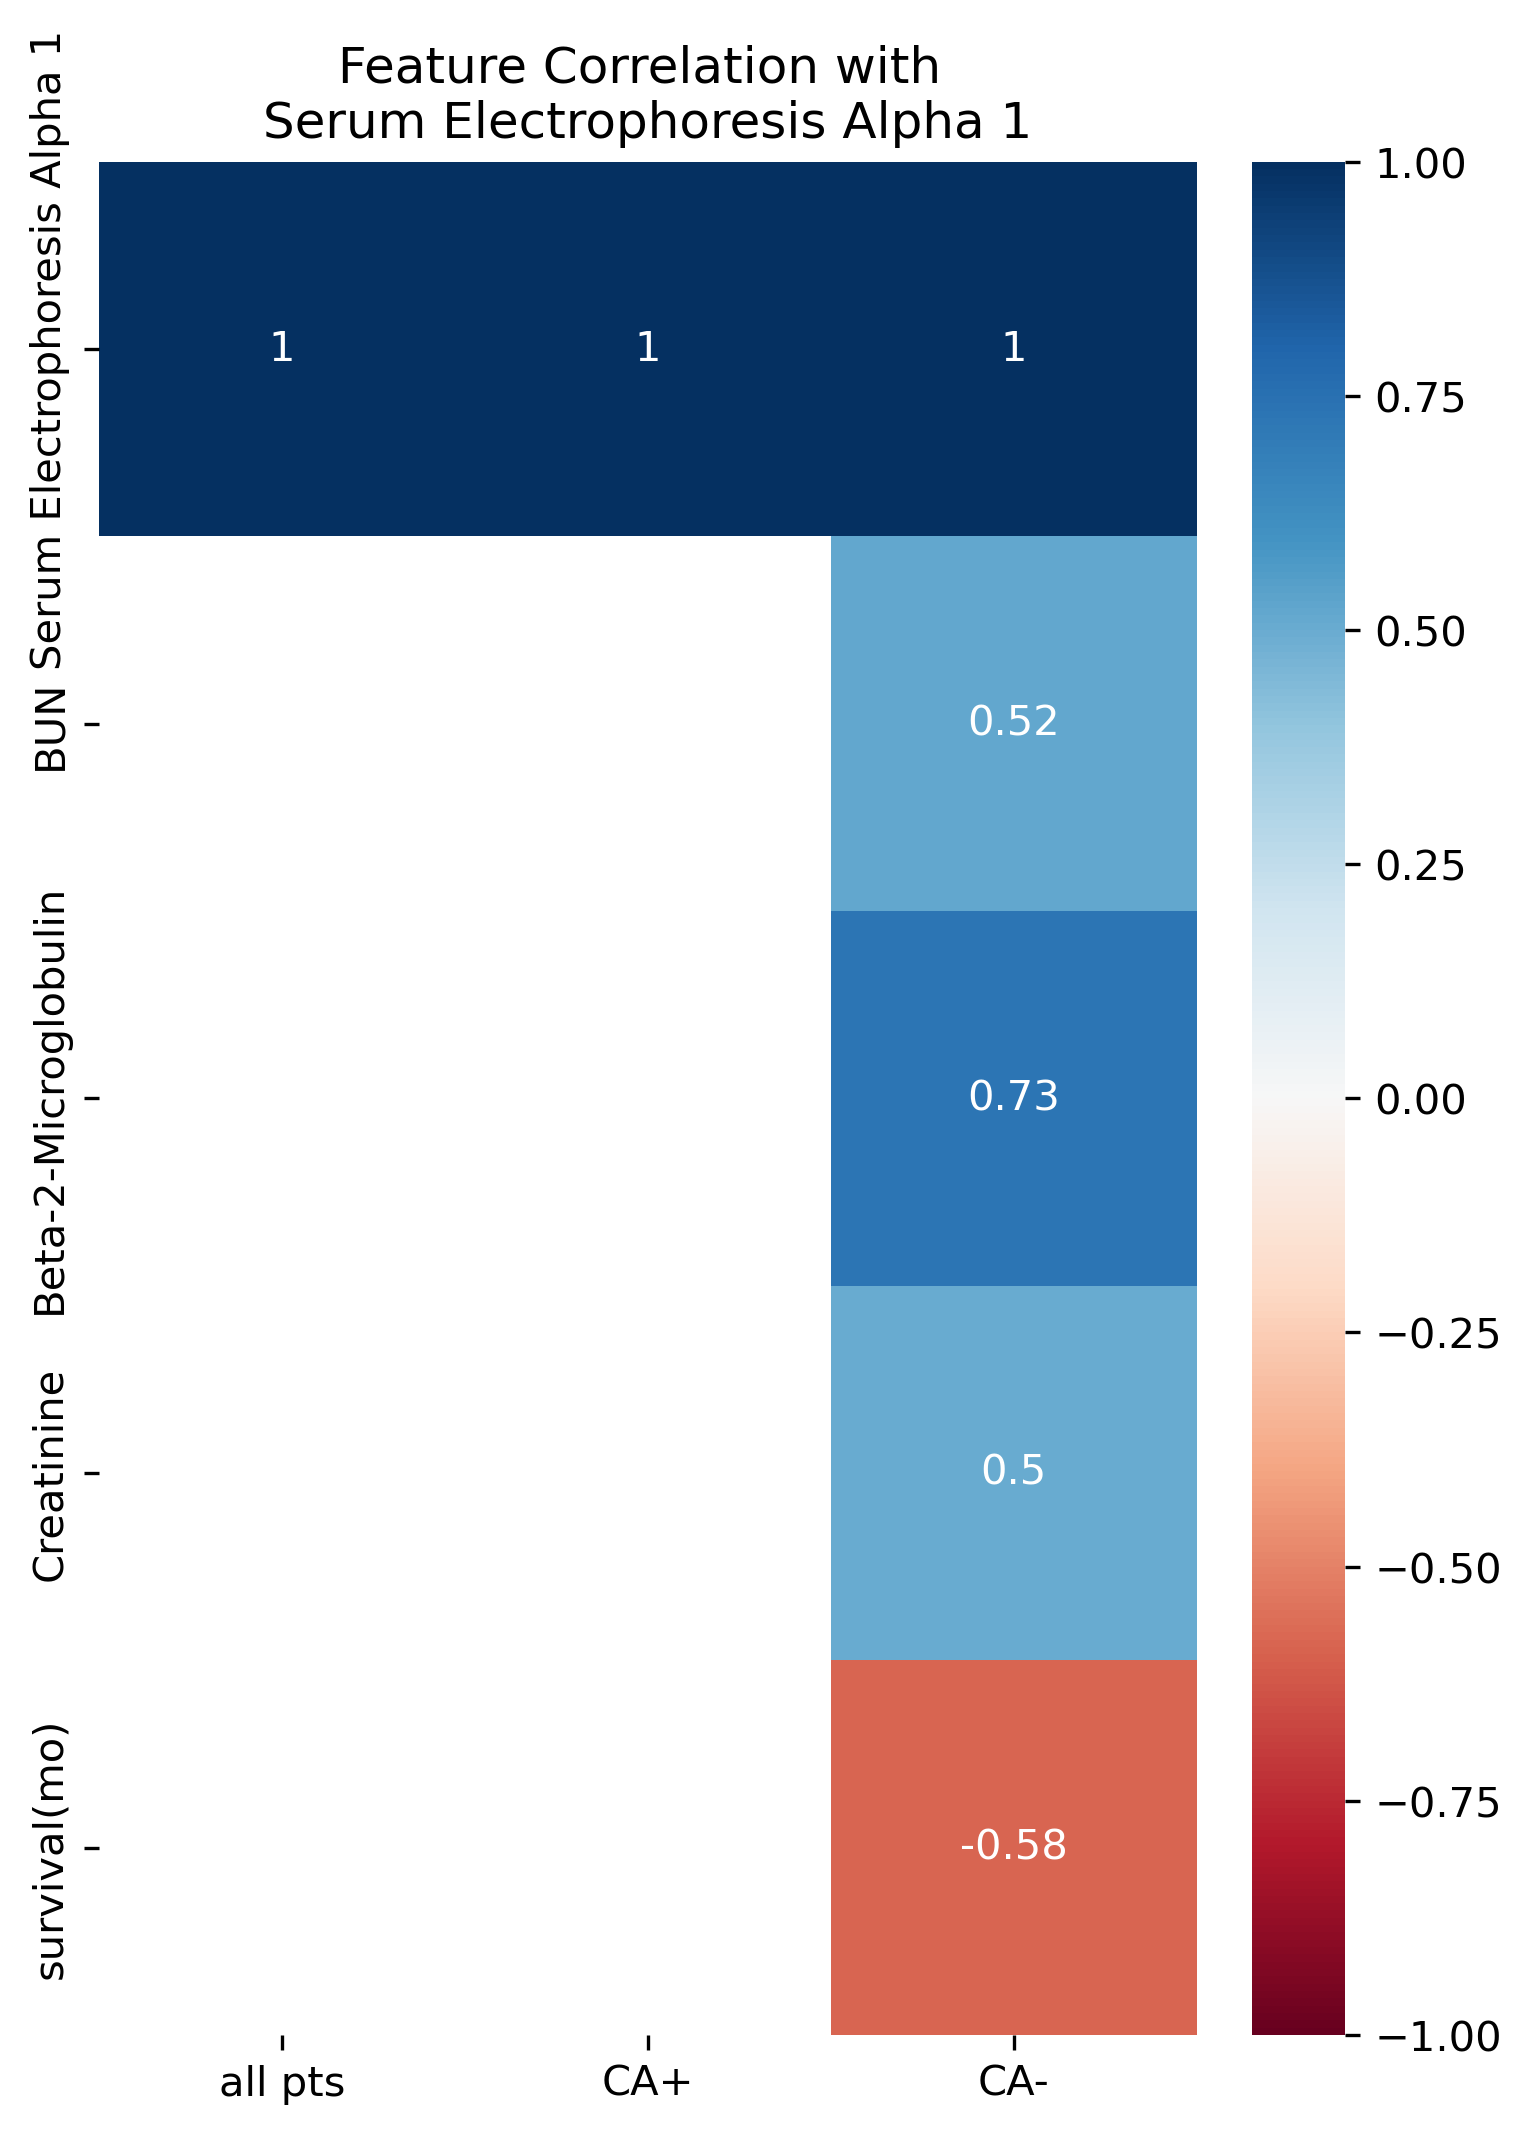

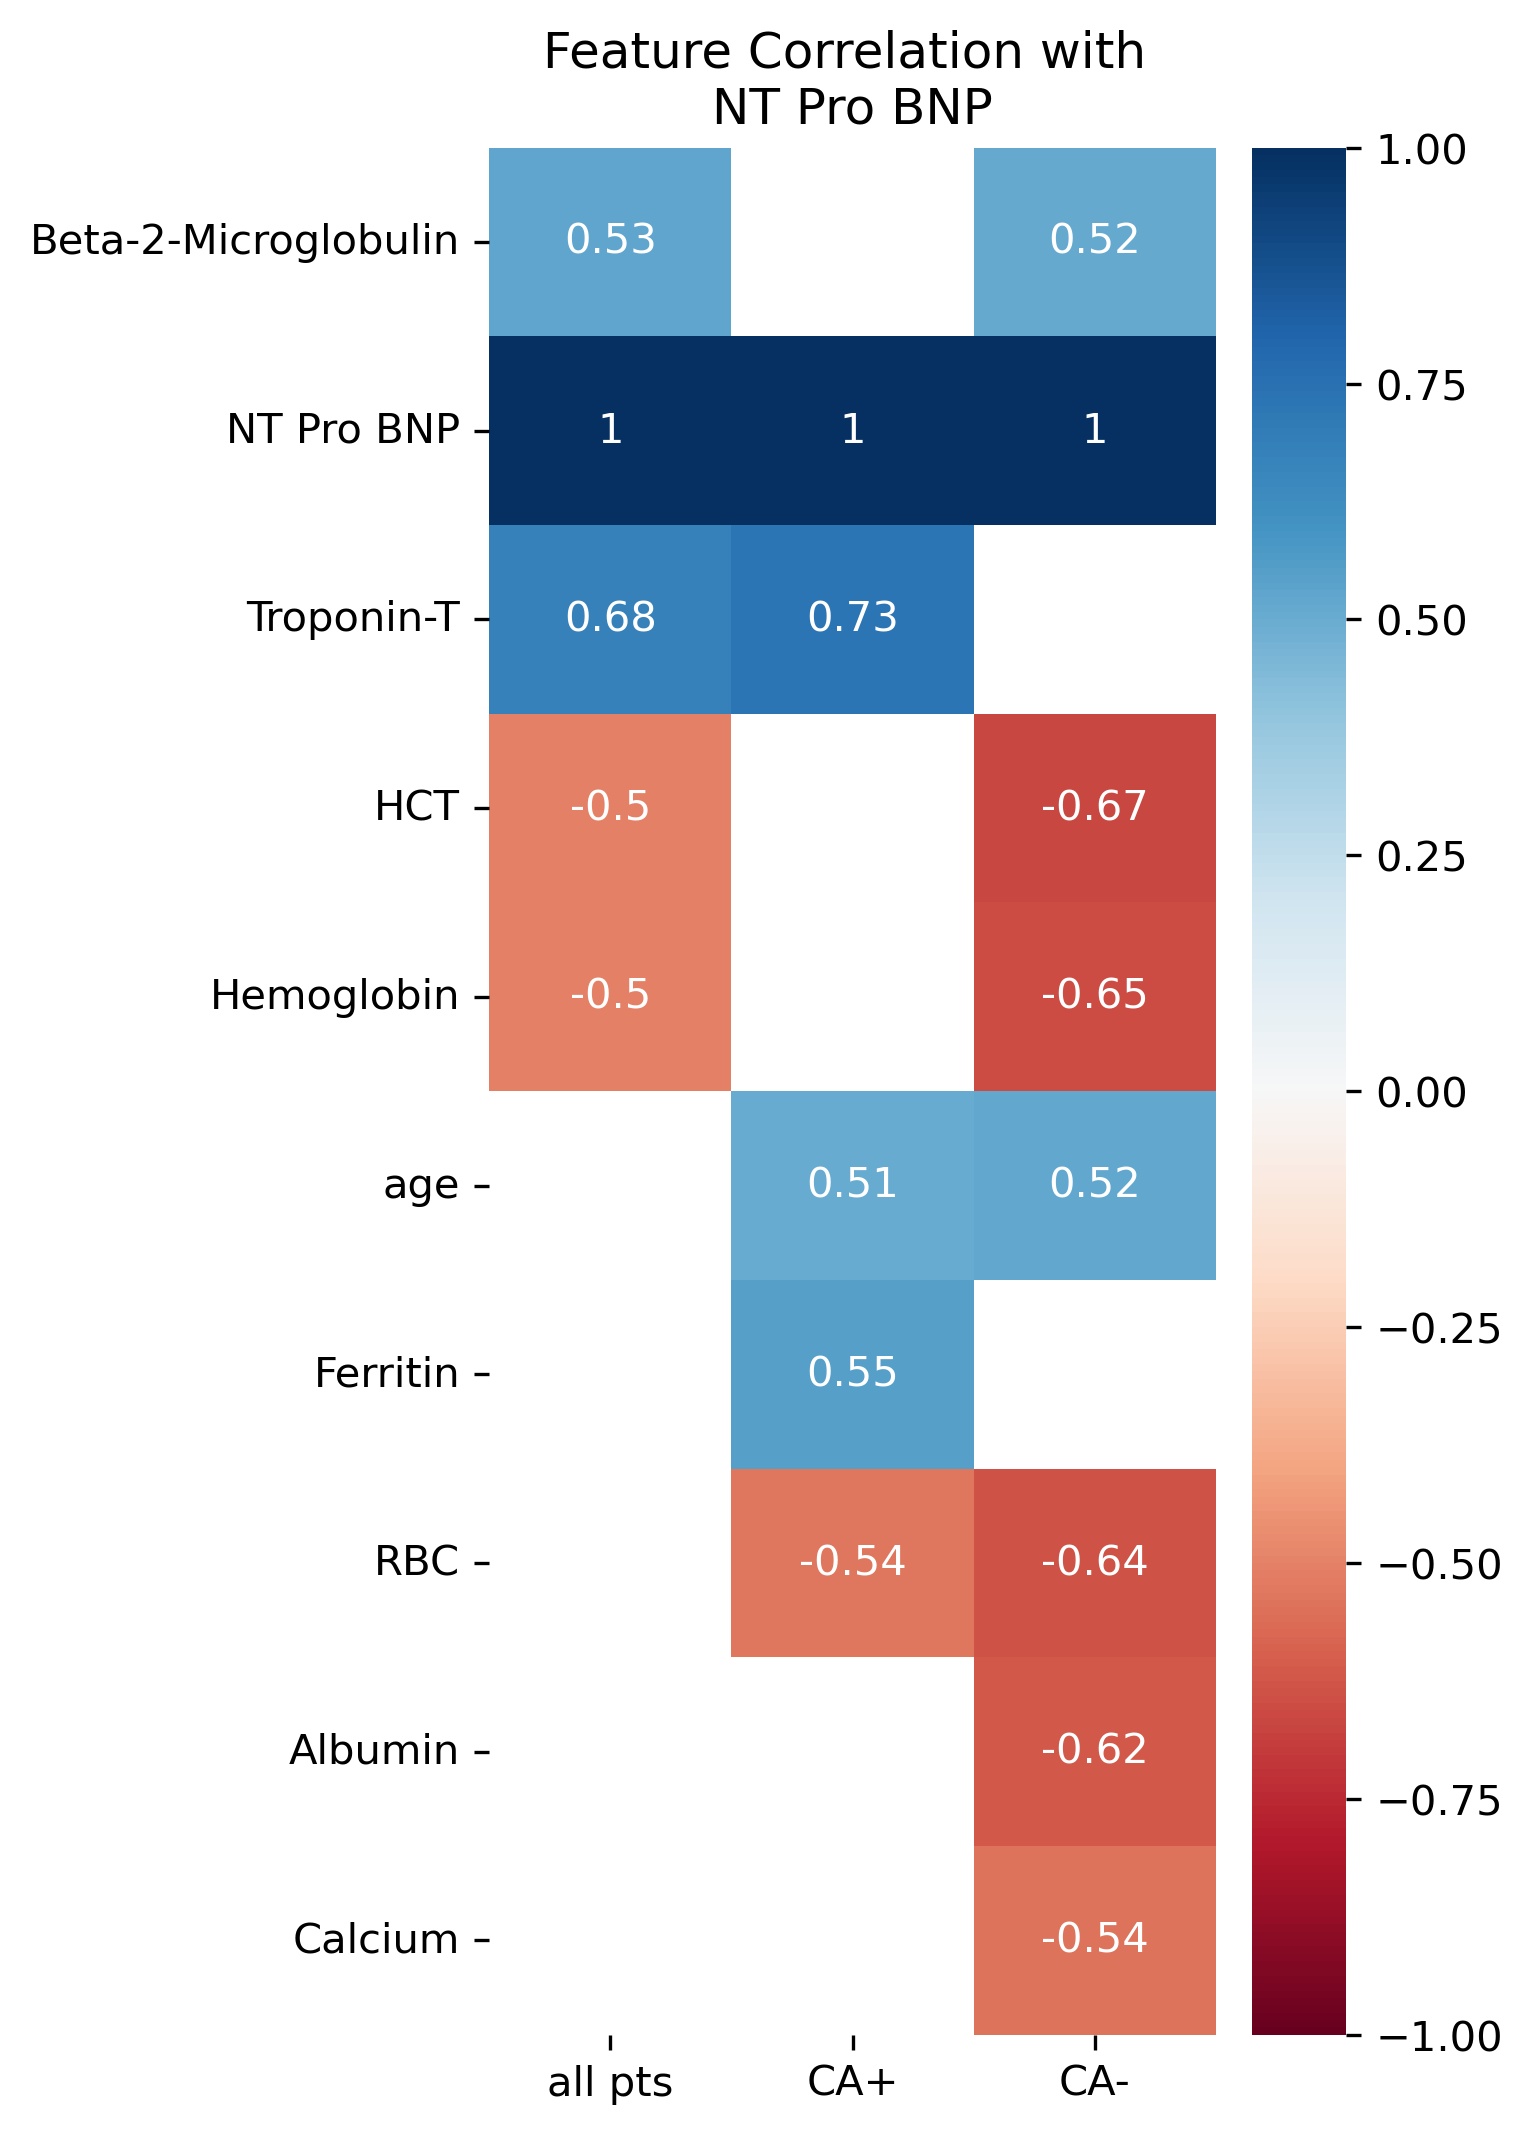

In [125]:
for feature_name in selected_features:
    feat_corr_sig_allpts = pd.concat([feature_correlation[feature_correlation[feature_name]>=0.5][feature_name], 
                                    feature_correlation[feature_correlation[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CApos = pd.concat([feature_correlation_CApositive[feature_correlation_CApositive[feature_name]>=0.5][feature_name], 
                                     feature_correlation_CApositive[feature_correlation_CApositive[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CAneg = pd.concat([feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]>=0.5][feature_name],
                                     feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_concat = pd.concat([feat_corr_sig_allpts,feat_corr_sig_CApos,feat_corr_sig_CAneg], axis = 1)
    feat_corr_sig_concat.columns = ['all pts', 'CA+', 'CA-']

    outputToExcel(df_data = feat_corr_sig_concat, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix ,
                       parent_dir= saving_dirrectory, folderName=makingFolder, sheetName=feature_name.replace("%", "").replace("/",""))

    fig, ax = plt.subplots(figsize = (5,7),layout = 'constrained')
    sns.heatmap(feat_corr_sig_concat, cmap= colormap, vmin= -1, vmax = 1, center = 0, annot = True, ax = ax)
    ax.set_title("Feature Correlation with \n"+ str(feature_name))

    figCommon =feature_name.replace("%", "").replace("/","") + "_heatmap_"
    # fig_file_out = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                         fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)
    # fig.savefig(fig_file_out, bbox_inches = 'tight')
    # fig_file_out_jpg = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                 fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out, fileExtension= '.jpg')
    # fig.savefig(fig_file_out_jpg, bbox_inches = 'tight')